In [1]:
# optimize_base_learners.py

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys

# Model imports
import xgboost as XGB
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor

try:
    from catboost import CatBoostRegressor
    catboost_available = True
except ImportError:
    print("Info: CatBoost is not installed. Skipping CBR model.")
    catboost_available = False
try:
    from lightgbm import LGBMRegressor
    lightgbm_available = True
except ImportError:
    print("Info: LightGBM is not installed. Skipping LGBM model.")
    lightgbm_available = False

# Scikit-learn and Scikit-optimize tool imports
from sklearn.model_selection import LeaveOneOut, LeavePOut
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.base import clone

print("All necessary libraries imported successfully.")

### --- Adjustable Configuration Parameters --- ###

# --- 1. Data Loading Settings ---
EXCEL_FILE_PATH = 'Band alignment-feature engineeringed.xlsx' # <--- Please replace this path with your actual Excel file path.

# --- 2. Bayesian Optimization Iterations ---
N_ITER_BAYESIAN = 50 # Number of Bayesian optimization iterations for each model. Higher values lead to
                     # a more thorough search but increase computation time.

# --- 3. Default Random State (for all model initializations and Bayesian optimization itself) ---
DEFAULT_MODEL_RANDOM_STATE = 0 # Ensures reproducibility of results across runs.

# --- 4. P-value for Cross-Validation (Leave-P-Out) ---
P_VALUE_FOR_BASE_TUNING = 1 # Set to 1 for Leave-One-Out Cross-Validation (LOOCV).
                           # For small datasets, LOOCV provides a robust estimate of model performance
                           # by training on N-1 samples and testing on 1, repeated N times.

# --- 5. Sub-model Selection Interface ---
# List the names of the sub-models for which you want to perform hyperparameter tuning.
# If a model's name is not present in this list, it will be excluded from the tuning process
# and subsequent stacking. You can easily disable a model by commenting out its entry in this list.
# Available model names typically include: 'XGBR', 'RF', 'GBRT', 'ETR', 'HGBR', 'CBR', 'LGBM'
ENABLED_SUBMODELS_FOR_TUNING_LIST = [
    'XGBR',
    'RF',
    'GBRT',
    'ETR',
    'HGBR',
    'CBR',
    'LGBM' 
]

# Ensure models in ENABLED_SUBMODELS_FOR_TUNING_LIST are actually available
if 'CBR' in ENABLED_SUBMODELS_FOR_TUNING_LIST and not catboost_available:
    print("Warning: CatBoost is not installed. 'CBR' removed from ENABLED_SUBMODELS_FOR_TUNING_LIST.")
    ENABLED_SUBMODELS_FOR_TUNING_LIST.remove('CBR')
if 'LGBM' in ENABLED_SUBMODELS_FOR_TUNING_LIST and not lightgbm_available:
    print("Warning: LightGBM is not installed. 'LGBM' removed from ENABLED_SUBMODELS_FOR_TUNING_LIST.")
    ENABLED_SUBMODELS_FOR_TUNING_LIST.remove('LGBM')

# Check if at least one model is enabled
if not ENABLED_SUBMODELS_FOR_TUNING_LIST:
    print("Error: No models enabled for hyperparameter tuning. Please check ENABLED_SUBMODELS_FOR_TUNING_LIST.")
    sys.exit(1)

# --- 6. Hyperparameter Search Space Definitions for Each Model ---
# These parameter ranges are set to be generally suitable, with adjustments for potentially small sample sizes
# when using Leave-P-Out Cross-Validation (e.g., P_VALUE_FOR_BASE_TUNING = 1).
parameter_XGBR = {
    'n_estimators': Integer(1, 500), # Number of boosting rounds (trees). Controls model complexity.
    'learning_rate': Real(0.01, 0.5, prior='log-uniform'), # Step size shrinkage used in update to prevent overfitting. Controls the contribution of each tree.
    'max_depth': Integer(1, 2), # Maximum depth of a tree. A smaller depth (e.g., 1-2) is often preferred for small datasets to prevent overfitting.
    'subsample': Real(0.5, 1.0, prior='uniform'), # Subsample ratio of the training instance. Prevents overfitting by sampling data.
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'), # Subsample ratio of columns when constructing each tree. Prevents overfitting by sampling features.
    'gamma': Real(0, 0.5, prior='uniform'), # Minimum loss reduction required to make a further partition on a leaf node. Higher gamma leads to more conservative models.
    'reg_alpha': Real(1e-3, 0.5, prior='log-uniform'), # L1 regularization term on weights. Encourages sparsity.
    'reg_lambda': Real(0.1, 5.0, prior='log-uniform') # L2 regularization term on weights. Prevents large weights.
}
parameter_RF = {
    'n_estimators': Integer(1, 500), # Number of trees in the forest. More trees generally improve performance but increase computation.
    'max_depth': Integer(1, 2), # Maximum depth of the tree. A smaller depth (e.g., 1-2) is often preferred for small datasets to prevent overfitting.
    'max_features': Categorical(['sqrt', 'log2']), # The number of features to consider when looking for the best split. 'sqrt' is common for regression.
    'min_samples_leaf': Integer(1, 3), # The minimum number of samples required to be at a leaf node. For small datasets, a slightly higher minimum (e.g., 1-3) can help prevent overfitting.
    'min_samples_split': Integer(2, 4) # The minimum number of samples required to split an internal node. For very small datasets, ensure this value is not too high to allow splits (e.g., 2 is the minimum).
}
parameter_CBR = {
    'iterations': Integer(1, 500), # The maximum number of trees to build.
    'learning_rate': Real(0.01, 0.5, prior='log-uniform'), # The learning rate. Controls the step size of gradient descent.
    'depth': Integer(1, 2), # Depth of the tree. A smaller depth (e.g., 1-2) is often preferred for small datasets to prevent overfitting.
    'l2_leaf_reg': Real(1, 5, prior='log-uniform'), # L2 regularization coefficient. Prevents overfitting by penalizing large weights.
    'rsm': Real(0.5, 1.0, prior='uniform'), # The sampling rate for columns (feature subsampling).
    'bootstrap_type': Categorical(['No']) # Defines the bootstrap type. 'No' disables internal sampling, which can be beneficial for very small datasets to ensure all samples are used.
}
parameter_LGBM = {
    'n_estimators': Integer(1, 500), # Number of boosting rounds.
    'learning_rate': Real(0.01, 0.5, prior='log-uniform'), # Boosting learning rate.
    'max_depth': Integer(1, 2), # Maximum tree depth for base learners. A smaller depth (e.g., 1-2) is often preferred for small datasets to prevent overfitting.
    'num_leaves': Integer(2, 4), # Maximum number of leaves in one tree. Should be related to `max_depth` (e.g., `num_leaves <= 2^max_depth`). Adjusted for small datasets.
    'subsample': Real(0.5, 1.0, prior='uniform'), # Subsample ratio of the training instance.
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'), # Subsample ratio of columns when constructing each tree.
    'reg_alpha': Real(1e-3, 0.5, prior='log-uniform'), # L1 regularization term on weights.
    'reg_lambda': Real(1e-3, 0.5, prior='log-uniform') # L2 regularization term on weights.
}
parameter_GBRT = {
    'n_estimators': Integer(1, 500), # The number of boosting stages to perform.
    'learning_rate': Real(0.01, 0.5, prior='log-uniform'), # Learning rate shrinks the contribution of each tree.
    'max_depth': Integer(1, 2), # Maximum depth of the individual regression estimators. A smaller depth (e.g., 1-2) is often preferred for small datasets to prevent overfitting.
    'max_features': Categorical(['sqrt', 'log2']), # The number of features to consider when looking for the best split.
    'min_samples_split': Integer(2, 4), # The minimum number of samples required to split an internal node.
    'min_samples_leaf': Integer(1, 3), # The minimum number of samples required to be at a leaf node.
    'subsample': Real(0.5, 1.0, prior='uniform') # The fraction of samples to be used for fitting the individual base learners.
}
parameter_HGBR = {
    'learning_rate': Real(0.01, 0.5, prior='log-uniform'), # The learning rate.
    'max_iter': Integer(1, 500), # The maximum number of iterations (boosting rounds). Corresponds to n_estimators.
    'max_depth': Integer(1, 2), # Maximum depth of the individual regression estimators. A smaller depth (e.g., 1-2) is often preferred for small datasets to prevent overfitting.
    'min_samples_leaf': Integer(1, 3), # The minimum number of samples required to be at a leaf node.
    'l2_regularization': Real(1e-6, 5.0, prior='log-uniform') # The L2 regularization term on weights.
}
parameter_ETR = {
    'n_estimators': Integer(1, 500), # The number of trees in the forest.
    'max_depth': Integer(1, 2), # Maximum depth of the tree. A smaller depth (e.g., 1-2) is often preferred for small datasets to prevent overfitting.
    'min_samples_split': Integer(2, 4), # The minimum number of samples required to split an internal node.
    'min_samples_leaf': Integer(1, 3), # The minimum number of samples required to be at a leaf node.
    'max_features': Categorical(['sqrt', 'log2', 1.0]) # The number of features to consider when looking for the best split. '1.0' means using all features.
}

### --- End Configuration Parameters --- ###

print("All configuration parameters and Bayesian optimization search spaces defined.")

# --- 2. Data Loading and Inspection ---
print(f"\nLoading data from '{EXCEL_FILE_PATH}'...")
try:
    data = pd.read_excel(EXCEL_FILE_PATH)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File '{EXCEL_FILE_PATH}' not found. Please check the file path.")
    sys.exit(1) # Exit the program

# --- User-defined Data Splitting ---
# X: Features are from the second column (index 1) up to the second-to-last column (exclusive, index -1)
X = data.iloc[:, 1:-1]
# Y: Target variable is the last column (index -1)
# Note: Adjust this index based on your specific target column.
# For example:
# If 'band alignment' is the second-to-last column: Y = data.iloc[:, -2]
# If 'shift range' is the very last column: Y = data.iloc[:, -1]
Y = data.iloc[:, -1]

target_column_name = Y.name if Y.name is not None else "Unnamed_Target_Column" # Get column name, assign default if none

# Dynamically describe the extracted feature column range
feature_col_names = X.columns.tolist()
if len(feature_col_names) > 1:
    feature_range_str = f"from column '{feature_col_names[0]}' to '{feature_col_names[-1]}'"
elif len(feature_col_names) == 1:
    feature_range_str = f"column '{feature_col_names[0]}'"
else:
    feature_range_str = "with no features" # Case where feature_col_names is empty

print(f"\nData split using specified method: Features {feature_range_str} and target '{target_column_name}'.")
print(f"X shape={X.shape}, Y shape={Y.shape}")


print("\nForcing data conversion to numeric types and handling non-numeric entries...")
initial_X_nan_count = X.isnull().sum().sum()
initial_Y_nan_count = Y.isnull().sum().sum()

X = X.apply(pd.to_numeric, errors='coerce')
Y = Y.apply(pd.to_numeric, errors='coerce')

new_X_nan_count = X.isnull().sum().sum()
new_Y_nan_count = Y.isnull().sum().sum()

if new_X_nan_count > initial_X_nan_count:
    print(f"Warning: {new_X_nan_count - initial_X_nan_count} non-numeric entries in feature data X were converted to NaN.")
if new_Y_nan_count > initial_Y_nan_count:
    print(f"Warning: {new_Y_nan_count - initial_Y_nan_count} non-numeric entries in target data Y were converted to NaN.")

print("\nChecking and filling NaN values in data...")
if X.isnull().any().any():
    warnings.warn("Warning: NaN values detected in feature data X. Filling with median.")
    X = X.fillna(X.median())
    print("NaN values in X filled with median.")
else:
    print("No NaN values detected in feature data X.")

if Y.isnull().any().any():
    warnings.warn("Warning: NaN values detected in target data Y. Filling with median.")
    y_median_val = Y.median()
    if pd.isna(y_median_val): # If the median itself is NaN, it means all Y values are NaN
        print("Error: All values in target data Y column are NaN. Cannot perform effective filling or model training. Please check the raw data.")
        sys.exit(1) # Exit the script
    Y = Y.fillna(y_median_val)
    print("NaN values in Y filled with median.")
else:
    print("No NaN values detected in target data Y.")

# Check if the number of samples is compatible with Leave-P-Out
if X.shape[0] <= P_VALUE_FOR_BASE_TUNING:
    print(f"Error: Dataset has too few samples ({X.shape[0]}) for Leave-{P_VALUE_FOR_BASE_TUNING}-Out CV. At least {P_VALUE_FOR_BASE_TUNING + 1} samples are required.")
    sys.exit(1) # Exit the program

print(f"Final data shape for analysis: X={X.shape}, Y={Y.shape}")
print("Note: This full dataset will be used for cross-validation tuning, no separate test set is created here.")

if isinstance(X, pd.DataFrame):
    feature_names_for_init = X.columns.tolist()
    print("X is a Pandas DataFrame, its column names will be used.")
else:
    print("Warning: Input X is not a Pandas DataFrame. Feature importances will use default names 'Feature_i'.")
    feature_names_for_init = [f'Feature_{i}' for i in range(X.shape[1])]

# --- 3. Cross-Validation Setup (using LeavePOut) ---
cross_Valid = LeavePOut(p=P_VALUE_FOR_BASE_TUNING)
n_splits_calculated = cross_Valid.get_n_splits(X)
print(f"\nUsing Leave-{P_VALUE_FOR_BASE_TUNING}-Out Cross-Validation ({n_splits_calculated} folds) for hyperparameter tuning on the ENTIRE dataset.")
print(f"Each training set size is {X.shape[0] - P_VALUE_FOR_BASE_TUNING} samples, and test set size is {P_VALUE_FOR_BASE_TUNING} samples.")
print("Note: Leave-P-Out CV provides more evaluation points for small sample sizes, helping the Bayesian optimizer find more stable hyperparameters.")


# --- Helper Function ---
def initialize_best_estimators(grid_searches_dict, enabled_models_list):
    """
    Initializes best base learner instances from BayesSearchCV results, filtered by the enabled_models_list.
    This function is primarily intended for use in evaluation or prediction scripts.

    Args:
        grid_searches_dict (dict): A dictionary containing BayesSearchCV results for each model.
        enabled_models_list (list): A list of model names that are enabled for tuning.

    Returns:
        dict: A dictionary of initialized best estimator instances.
    """
    estimators_init = {}
    # Define all possible models and their default parameters
    all_possible_models = {
        'XGBR': (XGB.XGBRegressor, {'objective': 'reg:squarederror', 'random_state': DEFAULT_MODEL_RANDOM_STATE}),
        'RF': (RandomForestRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE}),
        'GBRT': (GradientBoostingRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE}),
        'HGBR': (HistGradientBoostingRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE}),
        'ETR': (ExtraTreesRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE})
    }

    if catboost_available:
        all_possible_models['CBR'] = (CatBoostRegressor, {'verbose': False, 'random_state': DEFAULT_MODEL_RANDOM_STATE, 'allow_writing_files': False})
    if lightgbm_available:
        all_possible_models['LGBM'] = (LGBMRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE, 'verbosity': -1, 'objective': 'regression'})

    print("Initializing models...")
    for name, (model_class, fixed_params) in all_possible_models.items():
        if name not in enabled_models_list: # If the model is not in the enabled list, skip it
            print(f"  Model {name} is not in ENABLED_SUBMODELS_FOR_TUNING_LIST, skipping initialization.")
            continue

        if name in grid_searches_dict and grid_searches_dict[name] is not None and hasattr(grid_searches_dict[name], 'best_estimator_'):
            try:
                estimators_init[name] = grid_searches_dict[name].best_estimator_
                print(f"  Successfully initialized {name} with optimized parameters.")
            except Exception as e:
                print(f"  Error initializing {name} (from best_estimator_): {e}. This model will be skipped.")
                estimators_init[name] = None
        else:
            print(f"  No optimized results found for {name}. Attempting to initialize with default parameters.")
            try:
                estimators_init[name] = model_class(**fixed_params)
                print(f"  Successfully initialized {name} with default parameters.")
            except Exception as e:
                print(f"  Error initializing {name} (with default parameters): {e}. This model will be skipped.")
                estimators_init[name] = None

    initialized_estimators = {k: v for k, v in estimators_init.items() if v is not None}
    if not initialized_estimators:
         print("Warning: No models were successfully initialized!")
    return initialized_estimators

# --- 4. Dynamically Define Models and Parameter Mappings (based on ENABLED_SUBMODELS_FOR_TUNING_LIST) ---
# Stores all possible base model instances with their default parameters
all_possible_estimators_base = {
    'XGBR': XGB.XGBRegressor(random_state=DEFAULT_MODEL_RANDOM_STATE, objective='reg:squarederror'),
    'RF': RandomForestRegressor(random_state=DEFAULT_MODEL_RANDOM_STATE),
    'GBRT': GradientBoostingRegressor(random_state=DEFAULT_MODEL_RANDOM_STATE),
    'HGBR': HistGradientBoostingRegressor(random_state=DEFAULT_MODEL_RANDOM_STATE),
    'ETR': ExtraTreesRegressor(random_state=DEFAULT_MODEL_RANDOM_STATE)
}
if catboost_available: all_possible_estimators_base['CBR'] = CatBoostRegressor(verbose=False, random_state=DEFAULT_MODEL_RANDOM_STATE, allow_writing_files=False)
if lightgbm_available: all_possible_estimators_base['LGBM'] = LGBMRegressor(random_state=DEFAULT_MODEL_RANDOM_STATE, verbosity=-1, objective='regression')

# Stores all possible parameter search spaces
all_possible_params_base = {
    'XGBR': parameter_XGBR,
    'RF': parameter_RF,
    'GBRT': parameter_GBRT,
    'HGBR': parameter_HGBR,
    'ETR': parameter_ETR,
    'CBR': parameter_CBR,
    'LGBM': parameter_LGBM
}

# Filter models and parameters based on ENABLED_SUBMODELS_FOR_TUNING_LIST
estimators_for_bayes = {}
params_mapping = {}

for model_name in ENABLED_SUBMODELS_FOR_TUNING_LIST:
    if model_name in all_possible_estimators_base and model_name in all_possible_params_base:
        estimators_for_bayes[model_name] = all_possible_estimators_base[model_name]
        params_mapping[model_name] = all_possible_params_base[model_name]
    else:
        print(f"Warning: Model '{model_name}' is in ENABLED_SUBMODELS_FOR_TUNING_LIST, but its definition or parameter space is missing/unavailable. Skipping.")

if not estimators_for_bayes:
    print("Error: No valid models available for tuning based on ENABLED_SUBMODELS_FOR_TUNING_LIST. Please check configuration.")
    sys.exit(1)

print(f"\nModels to be tuned: {list(estimators_for_bayes.keys())}")


# --- 5. Set up and Run BayesSearchCV (currently for a single Y target) ---
grid_searches = {} # Stores the tuning result object for each model

print(f"\nStarting BayesSearchCV for each model on target '{target_column_name}' (n_iter = {N_ITER_BAYESIAN})...")

for name, estimator in estimators_for_bayes.items():
    start_time = time.time()
    print(f"--- Tuning {name} (Target: {target_column_name}) ---")
    
    # Ensure the model has a corresponding parameter space
    if name not in params_mapping:
        print(f"Warning: Parameter space not found for model {name}, skipping.")
        grid_searches[name] = None
        continue

    search_space = params_mapping[name]

    bayes_search = BayesSearchCV(
        estimator=clone(estimator), # Clone the estimator to ensure each tuning is independent
        search_spaces=search_space,
        scoring='neg_mean_squared_error', # Using negative MSE (for optimizing RMSE, as BayesSearchCV maximizes the score)
        n_iter=N_ITER_BAYESIAN,
        cv=cross_Valid, # Use LeavePOut (LOOCV)
        n_jobs=-1, # Typically -1 to use all available cores for parallel processing
        random_state=DEFAULT_MODEL_RANDOM_STATE,
        verbose=1 # Keep verbose=1 to output detailed information for each iteration
    )

    try:
        bayes_search.fit(X, Y) # Use the selected single target Y
        end_time = time.time()
        duration = end_time - start_time

        grid_searches[name] = bayes_search

        print(f"--- {name} (Target: {target_column_name}) Tuning Complete ---")
        # Note: bayes_search.best_score_ is negative MSE, so take the negative and square root to get RMSE
        print(f"Best Score (Leave-{P_VALUE_FOR_BASE_TUNING}-Out CV RMSE): {np.sqrt(-bayes_search.best_score_):.4f}")
        print(f"Best Parameters: {dict(bayes_search.best_params_)}")
        print(f"Total Tuning Duration: {duration:.2f} seconds")

    except Exception as e:
        end_time = time.time()
        duration = end_time - start_time
        print(f"\n!!! Error occurred during tuning {name} (Target: {target_column_name}): {e}")
        print(f"Tuning attempt duration: {duration:.2f} seconds")
        grid_searches[name] = None

print("\nAll model hyperparameter tuning complete.")

# --- 6. Final Results Overview ---
print("\n--- Final Optimization Results Overview ---")
print(f"\nTarget: {target_column_name}")
for name, result in grid_searches.items():
    if result is not None:
        print(f"  Model: {name}")
        # Note: result.best_score_ is negative MSE, so take the negative and square root to get RMSE
        print(f"    Best Leave-{P_VALUE_FOR_BASE_TUNING}-Out CV RMSE: {np.sqrt(-result.best_score_):.4f}")
        print(f"    Best Parameters: {result.best_params_}")
    else:
        print(f"  Model: {name} (Tuning Failed or Skipped)")

# X, Y, and grid_searches remain in memory for further use in the current session.
print("\nTraining data X, Y, and sub-model optimization results (grid_searches) are retained in the current session's memory.")
print("Please continue to run stacking evaluation and prediction scripts in the same session.")

print("\nScript execution complete.")


All necessary libraries imported successfully.
All configuration parameters and Bayesian optimization search spaces defined.

Loading data from 'Band alignment-feature engineeringed.xlsx'...
Data loaded successfully.

Data split using specified method: Features from column 'Chemical potential (eV)' to 'Overall surface area (Angstrom^2)' and target 'Band alignment (eV) '.
X shape=(7, 3), Y shape=(7,)

Forcing data conversion to numeric types and handling non-numeric entries...

Checking and filling NaN values in data...
No NaN values detected in feature data X.
No NaN values detected in target data Y.
Final data shape for analysis: X=(7, 3), Y=(7,)
Note: This full dataset will be used for cross-validation tuning, no separate test set is created here.
X is a Pandas DataFrame, its column names will be used.

Using Leave-1-Out Cross-Validation (7 folds) for hyperparameter tuning on the ENTIRE dataset.
Each training set size is 6 samples, and test set size is 1 samples.
Note: Leave-P-Out CV

D:\anaconda\envs\matsci-ai\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 'sqrt', 1, 2, 500] before, using random point [1, 'log2', 2, 2, 299]
  warnings.warn(


Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits


D:\anaconda\envs\matsci-ai\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 'sqrt', 1, 2, 500] before, using random point [1, 'sqrt', 2, 3, 88]
  warnings.warn(


Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits


D:\anaconda\envs\matsci-ai\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 'sqrt', 1, 2, 500] before, using random point [1, 'log2', 1, 3, 496]
  warnings.warn(


Fitting 7 folds for each of 1 candidates, totalling 7 fits


D:\anaconda\envs\matsci-ai\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 'log2', 1, 2, 500] before, using random point [2, 'log2', 2, 3, 66]
  warnings.warn(


Fitting 7 folds for each of 1 candidates, totalling 7 fits


D:\anaconda\envs\matsci-ai\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 'log2', 1, 2, 500] before, using random point [2, 'log2', 2, 4, 297]
  warnings.warn(


Fitting 7 folds for each of 1 candidates, totalling 7 fits


D:\anaconda\envs\matsci-ai\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 'log2', 1, 2, 500] before, using random point [1, 'sqrt', 2, 3, 221]
  warnings.warn(


Fitting 7 folds for each of 1 candidates, totalling 7 fits


D:\anaconda\envs\matsci-ai\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 'sqrt', 1, 2, 500] before, using random point [2, 'sqrt', 3, 4, 95]
  warnings.warn(


Fitting 7 folds for each of 1 candidates, totalling 7 fits
--- RF (Target: Band alignment (eV) ) Tuning Complete ---
Best Score (Leave-1-Out CV RMSE): 1.4583
Best Parameters: {'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Total Tuning Duration: 59.32 seconds
--- Tuning GBRT (Target: Band alignment (eV) ) ---
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidat

Libraries imported successfully.

Forcing data conversion to numeric types and handling non-numeric entries...

Checking and filling NaN values in data...
No NaN values detected in feature data X.
No NaN values detected in target data Y.
Dataset sample size N = 7
External evaluation will use Leave-3-Out Cross-Validation.
Total combinations for C(7, 3) = 35 folds.
Noise augmentation is disabled.
Initializing models...
  Successfully initialized XGBR with optimized parameters.
  Successfully initialized RF with optimized parameters.
  Successfully initialized GBRT with optimized parameters.
  Successfully initialized ETR with optimized parameters.
  Successfully initialized HGBR with optimized parameters.
  Successfully initialized CBR with optimized parameters.
  Successfully initialized LGBM with optimized parameters.

=== Starting Meta-Learner Hyperparameter Pre-tuning (One-time execution, using Leave-One-Out CV for OOF generation and internal CV) ===
Initializing models...
  Successf

C:\Users\zhuyi\AppData\Local\Temp\ipykernel_10680\3328024168.py:925: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_to_plot, y=features_to_plot, palette="viridis")


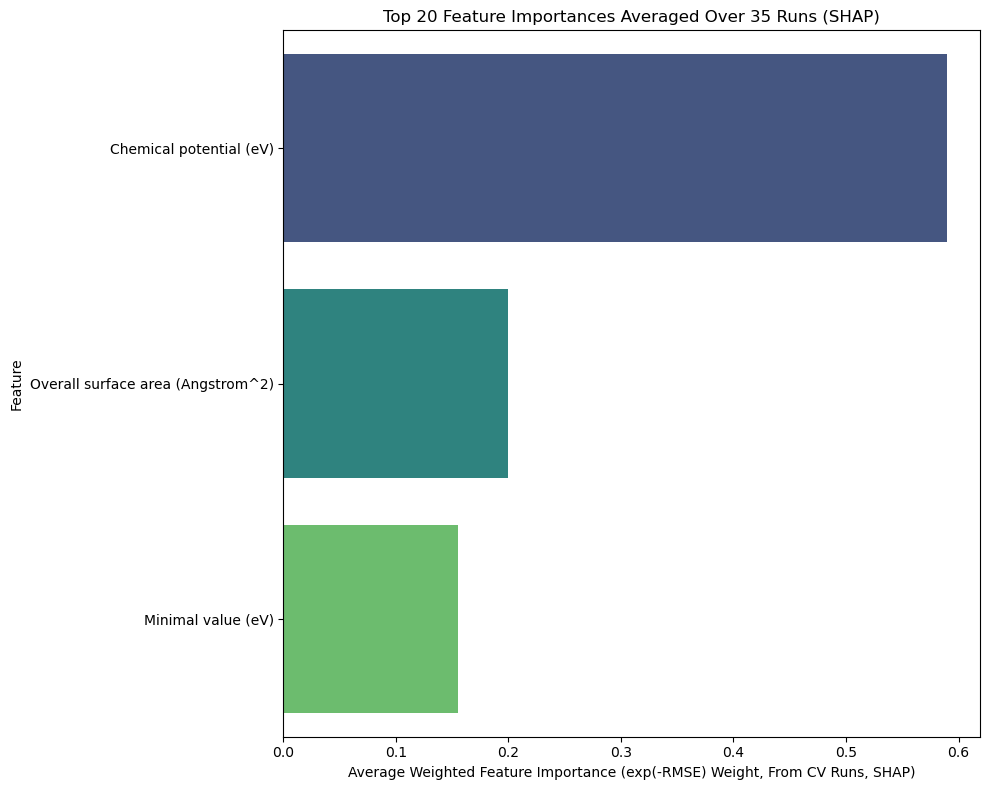

C:\Users\zhuyi\AppData\Local\Temp\ipykernel_10680\3328024168.py:1139: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_explanation, final_X_data_for_plot, plot_type="dot", show=False) # plot_type="dot" is the swarm plot



--- Aggregating raw SHAP data and plotting weighted average combined SHAP swarm plot (exp(-RMSE) weighted) ---
  exp(-RMSE) weighting coefficients (normalized): {'XGBR': 0.148802389373504, 'RF': 0.1213864269116487, 'GBRT': 0.19718465195378448, 'ETR': 0.17560977584141715, 'HGBR': 0.1566420973948126, 'CBR': 0.14515723143469256, 'LGBM': 0.055217427090140464}

--- Exporting aggregated SHAP swarm plot data to Excel/CSV ---
Successfully exported aggregated SHAP swarm plot data to: shap_swarm_data_20250710_231931.xlsx


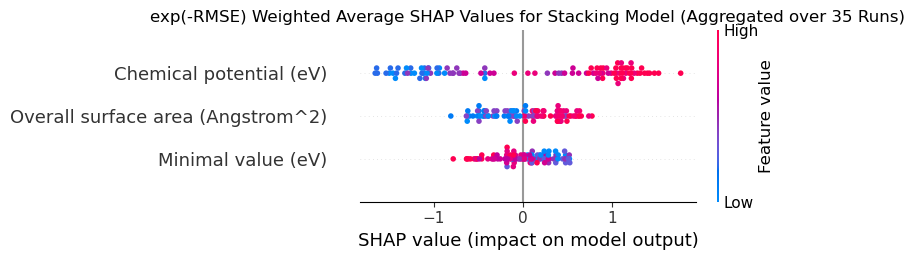


--- Exporting prediction results data to Excel/CSV (pivoted by model) ---
    Pivoting data to have models as columns...
    Data pivoting and column name cleaning complete.
Successfully exported pivoted data by model to: cv_predictions_pivoted_20250710_231931.xlsx

--- Exporting MAE and RMSE data per run to Excel/CSV (pivoted by model) ---
Successfully exported MAE and RMSE data per run to: cv_model_scores_per_run_pivoted_20250710_231931.xlsx

Script execution complete.


In [3]:
# evaluate_stacking_model.py

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools # Used for generating combinations for LeavePOut

# --- SHAP library import ---
import shap
# ------------------------

# Model imports
import xgboost as XGB
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor

# Import StackingRegressor and meta-learner
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Import CatBoost and LightGBM (if available)
try:
    from catboost import CatBoostRegressor
    catboost_available = True
except ImportError:
    print("Info: CatBoost is not installed. Skipping CBR model.")
    catboost_available = False
try:
    from lightgbm import LGBMRegressor
    lightgbm_available = True
except ImportError:
    print("Info: LightGBM is not installed. Skipping LGBM model.")
    lightgbm_available = False

# Scikit-learn Utilities
from sklearn.model_selection import LeaveOneOut, LeavePOut, KFold # KFold added for meta-learner internal CV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import clone
from skopt import BayesSearchCV
from skopt.space import Real

print("Libraries imported successfully.")

### --- Adjustable Configuration Parameters --- ###

# --- 1. Data Loading Settings (Note: Data X, Y, and grid_searches are expected to be available in the environment,
# typically by running 'optimize_base_learners.py' first.) ---

# --- 2. Bayesian Optimization Iterations ---
# META_LEARNER_N_ITER_BAYESIAN controls the number of Bayesian optimization iterations for the meta-learner.
META_LEARNER_N_ITER_BAYESIAN =  50  # Number of Bayesian optimization iterations for the meta-learner.
                                 # Higher values lead to a more thorough search but increase computation time.

# --- 3. Default Random State (for all model initializations and Bayesian optimization itself) ---
# Note: For LeavePOut and LeaveOneOut (shuffle=False), the splits are deterministic.
# The random_state primarily affects the internal randomness of the models.
DEFAULT_MODEL_RANDOM_STATE = 0 # Ensures reproducibility of results across runs.

# --- 4. External Cross-Validation and Overall Evaluation Parameters ---
# Adjust OUTER_CV_P_VALUE here to select the external evaluation method:
# P=1: Leave-One-Out (LOO) Cross-Validation. Each sample is a test set once.
# P=2: Leave-Two-Out (LTO) Cross-Validation. Each pair of samples is a test set once.
# P=3: Leave-Three-Out (L3O) Cross-Validation. Each triplet of samples is a test set once.
#
# Implications for dataset partitioning:
# - A higher P value means smaller training sets (N-P samples) and a larger number of total folds (combinations).
# - For N=7 samples:
#   - P=1 (LOO) results in C(7,1) = 7 combinations (folds).
#   - P=2 (LTO) results in C(7,2) = 21 combinations (folds).
#   - P=3 (L3O) results in C(7,3) = 35 combinations (folds).
# Choose P based on your dataset size and computational resources. For very small N, P=1 or P=2 is common.
OUTER_CV_P_VALUE = 3        # <-- P-value for external evaluation.
N_SEEDS_FOR_EVALUATION = None # <-- This value will be dynamically calculated based on OUTER_CV_P_VALUE.

# --- 5. Noise Intensity Control Interface ---
NOISE_SCALE_FACTOR = 0     # Factor for data augmentation (Gaussian noise). Set to 0 to disable.
                           # Adding noise to the training data can help regularize the model and
                           # prevent overfitting, especially beneficial for small datasets.
                           # By tuning this factor, one can potentially mitigate overfitting.
                           # In this specific work, noise augmentation is not utilized (factor is 0).

# --- 6. SHAP Feature Importance Calculation Parameters ---
# For KernelExplainer (used for non-tree models), the background data for SHAP calculation
# will directly use the current training set. No separate background sample limit is needed.

# --- 7. Plotting Parameters ---
N_FEATURES_TO_PLOT = 20 # Number of features to display in the feature importance bar plot.
PLOT_SHAP_SWARM_PLOT = True # Whether to generate the SHAP swarm plot.
SHAP_SWARM_SAMPLES_LIMIT = 1000 # Maximum number of samples to use for the SHAP swarm plot to prevent memory issues.
                                # Set to None to use all available samples.

# --- 8. Sub-model Selection Interface for Stacking ---
# List the names of the sub-models you wish to include in the Stacking model.
# If a model's name is not present in this list, it will be excluded from the Stacking ensemble.
# You can easily disable a model by commenting out its entry in this list.
# Available model names typically include: 'XGBR', 'RF', 'GBRT', 'ETR', 'HGBR', 'CBR', 'LGBM'
ENABLED_SUBMODELS_LIST = [
    'XGBR',
    'RF',
    'GBRT',
    'ETR',
    'HGBR',
    'CBR',
    'LGBM'
]
# Ensure models in ENABLED_SUBMODELS_LIST are actually available
if 'CBR' in ENABLED_SUBMODELS_LIST and not catboost_available:
    print("Warning: CatBoost is not installed. 'CBR' removed from ENABLED_SUBMODELS_LIST.")
    ENABLED_SUBMODELS_LIST.remove('CBR')
if 'LGBM' in ENABLED_SUBMODELS_LIST and not lightgbm_available:
    print("Warning: LightGBM is not installed. 'LGBM' removed from ENABLED_SUBMODELS_LIST.")
    ENABLED_SUBMODELS_LIST.remove('LGBM')

### --- End Configuration Parameters --- ###

# --- IMPORTANT: X, Y, and grid_searches variables must be defined in the environment before running this script. ---
# For example, by first executing the 'optimize_base_learners.py' script to provide these variables.
# If these variables are not defined, this script will fail with a NameError.

try:
    # Check if X is a DataFrame, which is important for getting indices
    if not isinstance(X, pd.DataFrame):
        print("Warning: Input X is not a Pandas DataFrame. Sample indices will use RangeIndex.")
        X_index = pd.RangeIndex(start=0, stop=len(X), step=1)
    else:
        X_index = X.index

    # Check Y's type and length
    if len(Y) != len(X):
         raise ValueError("Length of X and Y do not match!")
    if isinstance(Y, pd.DataFrame):
        if Y.shape[1] != 1:
            raise ValueError("If Y is a DataFrame, it should contain only one target column.")
        if not Y.index.equals(X_index):
            print("Warning: Y's index does not match X's index, which might cause issues. It is recommended to align indices beforehand.")
        Y = Y.iloc[:, 0] # Ensure Y is a Series

except NameError as e:
    print(f"Error: {e}. Variables 'X', 'Y', or 'grid_searches' are not defined in the current environment. Please ensure 'optimize_base_learners.py' is run first or load the required variables manually.")
    exit()
except ValueError as e:
    print(f"Data Error: {e}")
    exit()

# --- Robust NaN Filling Check ---
print("\nForcing data conversion to numeric types and handling non-numeric entries...")
initial_X_nan_count = X.isnull().sum().sum()
initial_Y_nan_count = Y.isnull().sum().sum()

X = X.apply(pd.to_numeric, errors='coerce')
Y = Y.apply(pd.to_numeric, errors='coerce')

new_X_nan_count = X.isnull().sum().sum()
new_Y_nan_count = Y.isnull().sum().sum()

if new_X_nan_count > initial_X_nan_count:
    print(f"Warning: {new_X_nan_count - initial_X_nan_count} non-numeric entries in feature data X were converted to NaN.")
if new_Y_nan_count > initial_Y_nan_count:
    print(f"Warning: {new_Y_nan_count - initial_Y_nan_count} non-numeric entries in target data Y were converted to NaN.")

print("\nChecking and filling NaN values in data...")
if X.isnull().any().any():
    warnings.warn("Warning: NaN values detected in feature data X. Filling with median.")
    X = X.fillna(X.median())
    print("NaN values in X filled with median.")
else:
    print("No NaN values detected in feature data X.")

if Y.isnull().any().any():
    warnings.warn("Warning: NaN values detected in target data Y. Filling with median.")
    y_median_val = Y.median()
    if pd.isna(y_median_val): # If the median itself is NaN, it means all Y values are NaN
        print("Error: All values in target data Y column are NaN. Cannot perform effective filling or model training. Please check the raw data.")
        exit() # Exit the script
    Y = Y.fillna(y_median_val)
    print("NaN values in Y filled with median.")
else:
    print("No NaN values detected in target data Y.")
# --- End Robust NaN Filling Check ---


# Check if the P-value for LeavePOut is valid
if OUTER_CV_P_VALUE >= X.shape[0]:
    print(f"Error: The P-value for Leave-P-Out ({OUTER_CV_P_VALUE}) must be less than the total number of samples ({X.shape[0]}). Please adjust OUTER_CV_P_VALUE.")
    exit()
if OUTER_CV_P_VALUE < 1:
    print(f"Error: The P-value for Leave-P-Out ({OUTER_CV_P_VALUE}) must be greater than or equal to 1. Please adjust OUTER_CV_P_VALUE.")
    exit()

print(f"Dataset sample size N = {X.shape[0]}")
print(f"External evaluation will use Leave-{OUTER_CV_P_VALUE}-Out Cross-Validation.")
# Generate all possible test set combinations (e.g., N=7, P=2 will generate C(7,2) = 21 combinations)
all_sample_indices = list(range(len(X)))
lpo_combinations = list(itertools.combinations(all_sample_indices, OUTER_CV_P_VALUE))
N_SEEDS_FOR_EVALUATION = len(lpo_combinations)
print(f"Total combinations for C({X.shape[0]}, {OUTER_CV_P_VALUE}) = {N_SEEDS_FOR_EVALUATION} folds.")


# --- Noise Intensity Control Interface ---
if NOISE_SCALE_FACTOR > 0:
    print(f"Gaussian noise augmentation is enabled with intensity factor: {NOISE_SCALE_FACTOR}")
else:
    print("Noise augmentation is disabled.")
np.random.seed(DEFAULT_MODEL_RANDOM_STATE) # Seed for noise generation

# --- Helper Functions ---
def initialize_best_estimators(grid_searches_dict, enabled_models_list):
    """
    Initializes best base learner instances from BayesSearchCV results, filtered by the enabled_models_list.
    This function is used to retrieve the optimized base models for stacking.

    Args:
        grid_searches_dict (dict): A dictionary containing BayesSearchCV results for each model.
        enabled_models_list (list): A list of model names that are enabled for stacking.

    Returns:
        dict: A dictionary of initialized best estimator instances.
    """
    estimators_init = {}
    # Define all possible models and their default parameters
    all_possible_models = {
        'XGBR': (XGB.XGBRegressor, {'objective': 'reg:squarederror', 'random_state': DEFAULT_MODEL_RANDOM_STATE}),
        'RF': (RandomForestRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE}),
        'GBRT': (GradientBoostingRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE}),
        'ETR': (ExtraTreesRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE}),
        'HGBR': (HistGradientBoostingRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE})
    }

    if catboost_available:
        all_possible_models['CBR'] = (CatBoostRegressor, {'verbose': False, 'random_state': DEFAULT_MODEL_RANDOM_STATE, 'allow_writing_files': False})
    if lightgbm_available:
        all_possible_models['LGBM'] = (LGBMRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE, 'verbosity': -1, 'objective': 'regression'})

    print("Initializing models...")
    for name, (model_class, fixed_params) in all_possible_models.items():
        if name not in enabled_models_list: # If the model is not in the enabled list, skip it
            print(f"  Model {name} is not in ENABLED_SUBMODELS_LIST, skipping initialization.")
            continue

        if name in grid_searches_dict and grid_searches_dict[name] is not None and hasattr(grid_searches_dict[name], 'best_estimator_'):
            try:
                estimators_init[name] = grid_searches_dict[name].best_estimator_
                print(f"  Successfully initialized {name} with optimized parameters.")
            except Exception as e:
                print(f"  Error initializing {name} (from best_estimator_): {e}. This model will be skipped.")
                estimators_init[name] = None
        else:
            print(f"  No optimized results found for {name}. Attempting to initialize with default parameters.")
            try:
                estimators_init[name] = model_class(**fixed_params)
                print(f"  Successfully initialized {name} with default parameters.")
            except Exception as e:
                print(f"  Error initializing {name} (with default parameters): {e}. This model will be skipped.")
                estimators_init[name] = None

    initialized_estimators = {k: v for k, v in estimators_init.items() if v is not None}
    if not initialized_estimators:
         print("Warning: No models were successfully initialized!")
    return initialized_estimators


# --- Define Meta-Learner Hyperparameter Search Space ---
meta_learner_params = {
    'elasticnet__alpha': Real(1e-5, 10.0, prior='log-uniform', name='elasticnet__alpha'),
    'elasticnet__l1_ratio': Real(0.0, 1.0, prior='uniform', name='elasticnet__l1_ratio')
}

# Global variables to store the best meta-learner instance (with fixed hyperparameters and coefficients)
# after a one-time pre-tuning.
global_fixed_meta_learner = None
global_fixed_meta_coeffs_dict = None # Stores the final fixed coefficients for printing and inspection.

# Define function to evaluate model performance and feature importance
def evaluate_models_manual_cv(run_idx, X_full, Y_full, X_full_index, grid_searches_dict, noise_factor,
                              fixed_meta_learner_instance, current_test_indices):
    """
    Performs a manual Leave-P-Out CV iteration to generate Out-Of-Fold (OOF) predictions,
    evaluate the Stacking model's performance, and calculate feature importances using SHAP values.

    Args:
        run_idx (int): Current run index for logging.
        X_full (pd.DataFrame or np.array): Full feature dataset.
        Y_full (pd.Series or np.array): Full target dataset.
        X_full_index (pd.Index or np.array): Original indices of X_full.
        grid_searches_dict (dict): Dictionary of pre-tuned base model results.
        noise_factor (float): Factor for Gaussian noise augmentation.
        fixed_meta_learner_instance (sklearn.pipeline.Pipeline): The pre-tuned and fixed meta-learner.
        current_test_indices (list): Indices of samples for the current test fold.

    Returns:
        dict: A dictionary containing evaluation metrics, feature importances, plot data,
              meta-learner coefficients, and raw SHAP values for the current run.
    """
    print(f"\n--- Starting Run {run_idx} ---")
  
    # Initialize base models, filtered by ENABLED_SUBMODELS_LIST
    best_estimators_dict = initialize_best_estimators(grid_searches_dict, ENABLED_SUBMODELS_LIST)

    if not best_estimators_dict:
        print(f"Run {run_idx}: No base models available for evaluation.")
        return {
            'submodel_r2_means': {}, 'submodel_rmse_means': {}, 'submodel_mae_means': {},
            'stacking_regressor_rmse_mean': np.nan, 'stacking_regressor_mae_mean': np.nan,
            'submodel_feature_importances': {}, 'weighted_feature_importances': {},
            'plot_data': [], 'meta_learner_coefficients': {},
            'raw_shap_values': {}, 'shap_expected_values': {}, 'X_val_data_for_shap': [],
            'all_scores_data_for_seed_fold': []
        }

    submodels = list(best_estimators_dict.items())
    submodel_names = [name for name, _ in submodels]

    # --- Initialize storage for Fold results (now for a single run's results) ---
    fold_r2_scores = {name: [] for name in submodel_names}
    fold_rmse_scores = {name: [] for name in submodel_names}
    fold_mae_scores = {name: [] for name in submodel_names}
    fold_rmse_scores['Stacking'] = []
    fold_mae_scores['Stacking'] = []
    all_plot_data_for_seed = []
    all_scores_data_for_seed_fold = []

    # --- Initialize accumulators for feature importances (sub-models) ---
    n_features = X_full.shape[1]
    fold_feature_importances_sums = {name: np.zeros(n_features) for name in submodel_names}
    fold_feature_importances_counts = {name: 0 for name in submodel_names}

    # --- New: Lists to collect raw SHAP values ---
    all_raw_shap_values_per_model = {name: [] for name in submodel_names}
    all_shap_expected_values_per_model = {name: [] for name in submodel_names}
    all_X_val_data_for_shap_folds = [] # Stores X_val_fold (DataFrame) for the current run

    print(f"  Run {run_idx}: Starting Leave-{OUTER_CV_P_VALUE}-Out evaluation...")
    is_X_dataframe = isinstance(X_full, pd.DataFrame)
    original_columns = X_full.columns if is_X_dataframe else [f'Feature_{i}' for i in range(n_features)]
    feature_names = list(original_columns)

    # --- External Leave-P-Out loop (now a single iteration, with train/val indices provided by the main loop) ---
    train_loc_idx = np.array(list(set(range(len(X_full))) - set(current_test_indices)))
    val_loc_idx = np.array(current_test_indices)

    train_original_indices = X_full_index[train_loc_idx]
    val_original_indices = X_full_index[val_loc_idx]

    if is_X_dataframe:
        X_train_fold, X_val_fold = X_full.loc[train_original_indices], X_full.loc[val_original_indices]
        if isinstance(Y_full, (pd.Series, pd.DataFrame)):
            Y_train_fold, Y_val_fold = Y_full.loc[train_original_indices], Y_full.loc[val_original_indices]
        else:
            Y_train_fold, Y_val_fold = Y_full[train_loc_idx], Y_full[val_loc_idx]
    else:
        X_train_fold, X_val_fold = X_full[train_loc_idx], X_full[val_loc_idx]
        Y_train_fold, Y_val_fold = Y_full[train_loc_idx], Y_full[val_loc_idx]

    # --- Crucial: Add the current X_val_fold to the list for SHAP aggregation ---
    all_X_val_data_for_shap_folds.append(X_val_fold)

    y_val_true_np = Y_val_fold.values if isinstance(Y_val_fold, (pd.Series, pd.DataFrame)) else np.array(Y_val_fold)
    y_train_true_np = Y_train_fold.values if isinstance(Y_train_fold, (pd.Series, pd.DataFrame)) else np.array(Y_train_fold)

    X_train_augmented = X_train_fold
    if noise_factor > 0:
        # Apply Gaussian noise to the training features for data augmentation.
        # This helps in regularizing the model and improving its generalization
        # by making it robust to small perturbations in the input data.
        X_train_fold_np = X_train_fold.values if is_X_dataframe else X_train_fold
        feature_std_devs = np.std(X_train_fold_np, axis=0)
        noise_std_devs = feature_std_devs * noise_factor + 1e-9
        noise = np.random.normal(loc=0.0, scale=noise_std_devs, size=X_train_fold_np.shape)
        if is_X_dataframe:
            X_train_augmented = pd.DataFrame(X_train_fold_np + noise, index=train_original_indices, columns=original_columns)
        else:
            X_train_augmented = X_train_fold_np + noise

    # --- Store current run's OOF predictions (from base learners) ---
    # Strict OOF prediction generation for meta-learner training on current external training set
    oof_preds_train = np.zeros((len(Y_train_fold), len(submodels)))
    oof_preds_val = np.zeros((len(Y_val_fold), len(submodels)))

    # Use LeaveOneOut on the current external training set to generate OOF predictions for meta-learner training.
    # For example, if external evaluation is Leave-Two-Out (P=2), the training set size is N-2 = 5 samples.
    # LeaveOneOut will generate 5 folds for this internal OOF generation.
    kf_for_oof_train = LeaveOneOut() # Base learners always use LeaveOneOut for OOF prediction generation for the meta-learner.
  
    for i, (name, estimator_template) in enumerate(submodels):
        current_model_oof_preds = np.zeros(len(Y_train_fold))
      
        try:
            # Generate OOF predictions for the current external training fold
            for inner_train_idx, inner_val_idx in kf_for_oof_train.split(X_train_augmented, Y_train_fold):
                X_inner_train = X_train_augmented.iloc[inner_train_idx] if is_X_dataframe else X_train_augmented[inner_train_idx]
                Y_inner_train = Y_train_fold.iloc[inner_train_idx] if isinstance(Y_train_fold, pd.Series) else Y_train_fold[inner_train_idx]
                X_inner_val = X_train_augmented.iloc[inner_val_idx] if is_X_dataframe else X_train_augmented[inner_val_idx]

                estimator_clone = clone(estimator_template)
                # Apply noise to X_inner_train if noise_factor > 0
                X_inner_train_augmented_for_oof = X_inner_train
                if noise_factor > 0:
                    # Apply Gaussian noise to the training features for data augmentation.
                    # This helps in regularizing the model and improving its generalization
                    # by making it robust to small perturbations in the input data.
                    X_inner_train_np_for_oof = X_inner_train.values if isinstance(X_inner_train, pd.DataFrame) else X_inner_train
                    feature_std_devs_for_oof = np.std(X_inner_train_np_for_oof, axis=0)
                    noise_std_devs_for_oof = feature_std_devs_for_oof * noise_factor + 1e-9
                    noise_for_oof = np.random.normal(loc=0.0, scale=noise_std_devs_for_oof, size=X_inner_train_np_for_oof.shape)
                    if isinstance(X_inner_train, pd.DataFrame):
                        X_inner_train_augmented_for_oof = pd.DataFrame(X_inner_train_np_for_oof + noise_for_oof, index=X_inner_train.index, columns=X_inner_train.columns)
                    else:
                        X_inner_train_augmented_for_oof = X_inner_train_np_for_oof + noise_for_oof

                estimator_clone.fit(X_inner_train_augmented_for_oof, Y_inner_train) # Use augmented data for training
                current_model_oof_preds[inner_val_idx] = estimator_clone.predict(X_inner_val) # Predict on original (non-augmented) inner_val_set
          
            oof_preds_train[:, i] = current_model_oof_preds
          
            # Train a final model on the full X_train_augmented for prediction on X_val_fold
            final_estimator_for_val_pred = clone(estimator_template)
            final_estimator_for_val_pred.fit(X_train_augmented, Y_train_fold)
            oof_preds_val[:, i] = final_estimator_for_val_pred.predict(X_val_fold)


        except Exception as fit_e:
             print(f"\nWarning: Run {run_idx}, Model {name} training or OOF generation failed: {fit_e}")
             oof_preds_train[:, i] = 0
             oof_preds_val[:, i] = 0
             # Record NaN scores for failed models
             all_scores_data_for_seed_fold.append({'Seed': run_idx, 'Fold': 0, 'Model': name, 'Metric': 'MAE', 'Value': np.nan})
             all_scores_data_for_seed_fold.append({'Seed': run_idx, 'Fold': 0, 'Model': name, 'Metric': 'RMSE', 'Value': np.nan})
             continue

        # Calculate metrics for base models on the current validation fold
        r2 = r2_score(Y_val_fold, oof_preds_val[:, i])
        rmse = np.sqrt(mean_squared_error(Y_val_fold, oof_preds_val[:, i]))
        mae = mean_absolute_error(Y_val_fold, oof_preds_val[:, i])

        fold_r2_scores[name].append(r2)
        fold_rmse_scores[name].append(rmse)
        fold_mae_scores[name].append(mae)
      
        # --- New: Record MAE and RMSE for each sub-model in the current run ---
        all_scores_data_for_seed_fold.append({'Seed': run_idx, 'Fold': 0, 'Model': name, 'Metric': 'MAE', 'Value': mae})
        all_scores_data_for_seed_fold.append({'Seed': run_idx, 'Fold': 0, 'Model': name, 'Metric': 'RMSE', 'Value': rmse})

        for idx, (actual, pred) in enumerate(zip(y_val_true_np, oof_preds_val[:, i])):
            original_index = val_original_indices[idx]
            all_plot_data_for_seed.append({
                'Seed': run_idx, 'Fold': 0, 'Model': name, # Fold unified to 0 for external loop
                'Set': 'Validation',
                'Actual': actual, 'Predicted': pred,
                'Sample_Index': original_index
            })
        for idx, (actual, pred) in enumerate(zip(y_train_true_np, oof_preds_train[:, i])):
            original_index = train_original_indices[idx]
            all_plot_data_for_seed.append({
                'Seed': run_idx, 'Fold': 0, 'Model': name, # Fold unified to 0 for external loop
                'Set': 'Train',
                'Actual': actual, 'Predicted': pred,
                'Sample_Index': original_index
            })

        # --- SHAP Feature Importance Calculation ---
        try:
            # Convert to NumPy array for SHAP compatibility
            X_val_fold_np = X_val_fold.values if isinstance(X_val_fold, pd.DataFrame) else X_val_fold
            X_train_fold_np = X_train_fold.values if isinstance(X_train_fold, pd.DataFrame) else X_train_fold

            # Ensure validation set is not empty, otherwise SHAP will error
            if X_val_fold_np.shape[0] == 0:
                print(f"Warning: Run {run_idx}, Model {name}: Validation set is empty, skipping SHAP calculation.")
                continue

            # Check model type to select appropriate Explainer
            if isinstance(final_estimator_for_val_pred, (XGB.XGBRegressor, RandomForestRegressor,
                                           GradientBoostingRegressor, CatBoostRegressor, LGBMRegressor,
                                           ExtraTreesRegressor, HistGradientBoostingRegressor)):
                explainer = shap.TreeExplainer(final_estimator_for_val_pred)
                shap_values = explainer.shap_values(X_val_fold_np)
                expected_value = explainer.expected_value
            else: # For non-tree models, use KernelExplainer
                # For N=7, P=2, training set has 5 samples, so background data is the training set itself.
                # Ensure background data is not empty.
                if X_train_fold_np.shape[0] == 0:
                    print(f"Warning: Run {run_idx}, Model {name}: Training set is empty, cannot generate background data for KernelExplainer, skipping SHAP calculation.")
                    continue

                background_data = X_train_fold_np
              
                print(f"  Run {run_idx}, Model {name}: Calculating SHAP using KernelExplainer (may be slow)...")
                explainer = shap.KernelExplainer(final_estimator_for_val_pred.predict, background_data)
                shap_values = explainer.shap_values(X_val_fold_np)
                expected_value = explainer.expected_value
          
            # --- Store raw SHAP values and expected values ---
            all_raw_shap_values_per_model[name].append(shap_values)
            all_shap_expected_values_per_model[name].append(expected_value)

            # Global feature importance from SHAP is typically the mean absolute SHAP value (for bar plots)
            importances = np.mean(np.abs(shap_values), axis=0)

            if importances.shape[0] == n_features:
                 fold_feature_importances_sums[name] += importances
                 fold_feature_importances_counts[name] += 1
            else:
                print(f"Warning: Run {run_idx}, Model {name} SHAP importance dimension mismatch.")

        except Exception as imp_e:
             print(f"\nWarning: Run {run_idx}, Model {name} error getting SHAP importance: {imp_e}")
        # --- END SHAP Calculation ---

    # --- Train and Evaluate Meta-Learner (ElasticNet) ---
    if np.all(oof_preds_train == 0) or np.any(np.isnan(oof_preds_train)):
        print(f"Warning: Run {run_idx}: OOF predictions are all zeros or contain NaN, skipping meta-learner training.")
        fold_rmse_scores['Stacking'].append(np.nan)
        fold_mae_scores['Stacking'].append(np.nan)
        # Record NaN scores for failed models
        all_scores_data_for_seed_fold.append({'Seed': run_idx, 'Fold': 0, 'Model': 'Stacking', 'Metric': 'MAE', 'Value': np.nan})
        all_scores_data_for_seed_fold.append({'Seed': run_idx, 'Fold': 0, 'Model': 'Stacking', 'Metric': 'RMSE', 'Value': np.nan})
        return {
            'submodel_r2_means': {}, 'submodel_rmse_means': {}, 'submodel_mae_means': {},
            'stacking_regressor_rmse_mean': np.nan,
            'stacking_regressor_mae_mean': np.nan,
            'submodel_feature_importances': {}, 'weighted_feature_importances': {},
            'plot_data': all_plot_data_for_seed, 'meta_learner_coefficients': {},
            'raw_shap_values': {}, 'shap_expected_values': {}, 'X_val_data_for_shap': [],
            'all_scores_data_for_seed_fold': []
        }

    # Use the globally fixed meta-learner instance for prediction, no re-training here.
    try:
        y_pred_val_stacking = fixed_meta_learner_instance.predict(oof_preds_val)
        y_pred_train_stacking = fixed_meta_learner_instance.predict(oof_preds_train)
    except Exception as meta_pred_e:
        print(f"\nWarning: Run {run_idx}, prediction with fixed meta-learner failed: {meta_pred_e}")
        fold_rmse_scores['Stacking'].append(np.nan)
        fold_mae_scores['Stacking'].append(np.nan)
        all_scores_data_for_seed_fold.append({'Seed': run_idx, 'Fold': 0, 'Model': 'Stacking', 'Metric': 'MAE', 'Value': np.nan})
        all_scores_data_for_seed_fold.append({'Seed': run_idx, 'Fold': 0, 'Model': 'Stacking', 'Metric': 'RMSE', 'Value': np.nan})
        return {
            'submodel_r2_means': {name: np.nan for name in submodel_names},
            'submodel_rmse_means': {name: np.nan for name in submodel_names},
            'submodel_mae_means': {name: np.nan for name in submodel_names},
            'stacking_regressor_rmse_mean': np.nan,
            'stacking_regressor_mae_mean': np.nan,
            'submodel_feature_importances': {}, 'weighted_feature_importances': {},
            'plot_data': all_plot_data_for_seed, 'meta_learner_coefficients': {},
            'raw_shap_values': {},
            'shap_expected_values': {},
            'X_val_data_for_shap': [],
            'all_scores_data_for_seed_fold': all_scores_data_for_seed_fold
        }

    rmse_stacking = np.sqrt(mean_squared_error(Y_val_fold, y_pred_val_stacking))
    mae_stacking = mean_absolute_error(Y_val_fold, y_pred_val_stacking)

    fold_rmse_scores['Stacking'].append(rmse_stacking)
    fold_mae_scores['Stacking'].append(mae_stacking)
  
    # --- New: Record MAE and RMSE for the Stacking model in the current run ---
    all_scores_data_for_seed_fold.append({'Seed': run_idx, 'Fold': 0, 'Model': 'Stacking', 'Metric': 'MAE', 'Value': mae_stacking})
    all_scores_data_for_seed_fold.append({'Seed': run_idx, 'Fold': 0, 'Model': 'Stacking', 'Metric': 'RMSE', 'Value': rmse_stacking})

    for idx, (actual, pred) in enumerate(zip(y_val_true_np, y_pred_val_stacking)):
        original_index = val_original_indices[idx]
        all_plot_data_for_seed.append({
            'Seed': run_idx, 'Fold': 0, 'Model': 'Stacking',
            'Set': 'Validation',
            'Actual': actual, 'Predicted': pred,
            'Sample_Index': original_index
        })
    for idx, (actual, pred) in enumerate(zip(y_train_true_np, y_pred_train_stacking)):
        original_index = train_original_indices[idx]
        all_plot_data_for_seed.append({
            'Seed': run_idx, 'Fold': 0, 'Model': 'Stacking',
            'Set': 'Train',
            'Actual': actual, 'Predicted': pred,
            'Sample_Index': original_index
        })


    # --- End of Run ---
    print(f"\n  Run {run_idx}: Leave-{OUTER_CV_P_VALUE}-Out evaluation complete.")

    # --- Calculate average scores (now just taking the values from the list for a single run) ---
    submodel_r2_means = {name: scores[0] if scores else np.nan for name, scores in fold_r2_scores.items() if scores}
    submodel_rmse_means = {name: scores[0] if scores else np.nan for name, scores in fold_rmse_scores.items() if scores}
    submodel_mae_means = {name: scores[0] if scores else np.nan for name, scores in fold_mae_scores.items() if scores}
    stacking_regressor_rmse_mean = fold_rmse_scores['Stacking'][0] if fold_rmse_scores['Stacking'] else np.nan
    stacking_regressor_mae_mean = fold_mae_scores['Stacking'][0] if fold_mae_scores['Stacking'] else np.nan

    # --- Calculate Feature Importances (Sub-models) ---
    print(f"  Run {run_idx}: Calculating feature importances based on current run (SHAP)...")
    submodel_avg_seed_importances = {}
    feature_importances_weighted_sum = np.zeros(n_features)
    total_exp_rmse_weighting = 0 # Sum of exp(-RMSE) for weighting
    for name in submodel_names:
        count = fold_feature_importances_counts[name]
        if count > 0:
            avg_importances = fold_feature_importances_sums[name] / count
            sum_avg_importances = np.sum(avg_importances)
            if sum_avg_importances > 1e-9:
                importances_normalized = avg_importances / sum_avg_importances
            else:
                importances_normalized = np.zeros_like(avg_importances)
            submodel_avg_seed_importances[name] = dict(zip(feature_names, importances_normalized))
          
            # Use exp(-RMSE) for weighting
            model_rmse_val = submodel_rmse_means.get(name, np.nan)
            if not np.isnan(model_rmse_val): # RMSE will not be negative, only check for NaN
                 weight = np.exp(-model_rmse_val) # exp(-RMSE)
                 feature_importances_weighted_sum += importances_normalized * weight
                 total_exp_rmse_weighting += weight
        else:
            submodel_avg_seed_importances[name] = {}
  
    if total_exp_rmse_weighting > 1e-9:
        weighted_feature_importances_vector = feature_importances_weighted_sum / total_exp_rmse_weighting
    else:
        weighted_feature_importances_vector = np.zeros(n_features)
    weighted_feature_importances_dict = dict(zip(feature_names, weighted_feature_importances_vector))
    print(f"  Run {run_idx}: Feature importance calculation complete (SHAP).")

    # Return the globally fixed meta-learner coefficients
    return {
        'submodel_r2_means': submodel_r2_means,
        'submodel_rmse_means': submodel_rmse_means,
        'submodel_mae_means': submodel_mae_means,
        'stacking_regressor_rmse_mean': stacking_regressor_rmse_mean,
        'stacking_regressor_mae_mean': stacking_regressor_mae_mean,
        'submodel_feature_importances': submodel_avg_seed_importances,
        'weighted_feature_importances': weighted_feature_importances_dict,
        'plot_data': all_plot_data_for_seed,
        'meta_learner_coefficients': global_fixed_meta_coeffs_dict, # Always return the fixed global coefficients
        'raw_shap_values': all_raw_shap_values_per_model, # New return
        'shap_expected_values': all_shap_expected_values_per_model, # New return
        'X_val_data_for_shap': all_X_val_data_for_shap_folds, # New return
        'all_scores_data_for_seed_fold': all_scores_data_for_seed_fold # New return
    }

# === Main Execution Flow ===
# Get X's index and feature names
if isinstance(X, pd.DataFrame):
    X_index = X.index
    feature_names_list = X.columns.tolist()
else:
    print("Warning: Input X is not a Pandas DataFrame. Feature importances will use default names 'Feature_i', and sample indices will use RangeIndex.")
    X_index = pd.RangeIndex(start=0, stop=len(X), step=1)
    feature_names_list = [f'Feature_{i}' for i in range(X.shape[1])]

# Get available model names (filtered by ENABLED_SUBMODELS_LIST)
try:
    _initial_estimators = initialize_best_estimators(grid_searches, ENABLED_SUBMODELS_LIST)
    model_names_available = list(_initial_estimators.keys())
    if not model_names_available:
        print("Error: No models successfully initialized, cannot proceed. Please check ENABLED_SUBMODELS_LIST.")
        exit()
    del _initial_estimators
except Exception as e:
    print(f"Error: An error occurred while trying to initialize models to get names: {e}")
    exit()

# --- Meta-Learner Hyperparameter Pre-tuning Stage (One-time execution) ---
# The meta-learner tuning uses Leave-One-Out CV for OOF generation and internal CV, then fixes coefficients.
print(f"\n=== Starting Meta-Learner Hyperparameter Pre-tuning (One-time execution, using Leave-One-Out CV for OOF generation and internal CV) ===")

# Generate OOF predictions for ALL N samples for this meta-tuning iteration
oof_preds_full_current_iter = np.zeros((len(X), len(model_names_available)))

# Initialize base estimators, filtered by ENABLED_SUBMODELS_LIST
temp_base_estimators = initialize_best_estimators(grid_searches, ENABLED_SUBMODELS_LIST)
if not temp_base_estimators:
    print("Warning: Failed to initialize base learners, skipping meta-learner tuning.")
    # Fallback to a default ElasticNet if base learners fail
    global_fixed_meta_learner = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(random_state=DEFAULT_MODEL_RANDOM_STATE, max_iter=2000))
    ])
    # Also set default coefficients if no tuning happens
    global_fixed_meta_coeffs_dict = {name: np.nan for name in model_names_available}
else:
    # Use LeaveOneOut to generate OOF predictions on the entire dataset (e.g., N=7)
    loo_for_full_oof = LeaveOneOut() # Meta-learner OOF generation always uses LeaveOneOut.
  
    # This check is mostly for general robustness; for N=7, LOOCV is fine.
    if loo_for_full_oof.get_n_splits(X) < 2:
        print(f"Warning: LeaveOneOut cannot generate at least 2 folds with {len(X)} samples. Skipping meta-learner tuning.")
        global_fixed_meta_learner = Pipeline([
            ('scaler', StandardScaler()),
            ('elasticnet', ElasticNet(random_state=DEFAULT_MODEL_RANDOM_STATE, max_iter=2000))
        ])
        global_fixed_meta_coeffs_dict = {name: np.nan for name in model_names_available}
    else:
        for i, (name, estimator_template) in enumerate(temp_base_estimators.items()):
            print(f"  Generating OOF predictions for model {name} (for meta-learner tuning)...")
            fold_preds = np.zeros(len(X))
          
            # Generate OOF predictions using LeaveOneOut
            for train_idx, val_idx in loo_for_full_oof.split(X, Y):
                X_inner_train = X.iloc[train_idx] if isinstance(X, pd.DataFrame) else X[train_idx]
                Y_inner_train = Y.iloc[train_idx] if isinstance(Y, pd.Series) else Y[train_idx]
                X_inner_val = X.iloc[val_idx] if isinstance(X, pd.DataFrame) else X[val_idx]

                estimator_clone = clone(estimator_template)
                # Apply noise to X_inner_train if NOISE_SCALE_FACTOR > 0
                X_inner_train_augmented_for_oof_meta_tune = X_inner_train
                if NOISE_SCALE_FACTOR > 0:
                    # Apply Gaussian noise to the training features for data augmentation.
                    # This helps in regularizing the model and improving its generalization
                    # by making it robust to small perturbations in the input data.
                    X_inner_train_np_for_oof_meta_tune = X_inner_train.values if isinstance(X_inner_train, pd.DataFrame) else X_inner_train
                    feature_std_devs_for_oof_meta_tune = np.std(X_inner_train_np_for_oof_meta_tune, axis=0)
                    noise_std_devs_for_oof_meta_tune = feature_std_devs_for_oof_meta_tune * NOISE_SCALE_FACTOR + 1e-9
                    noise_for_oof_meta_tune = np.random.normal(loc=0.0, scale=noise_std_devs_for_oof_meta_tune, size=X_inner_train_np_for_oof_meta_tune.shape)
                    if isinstance(X_inner_train, pd.DataFrame):
                        X_inner_train_augmented_for_oof_meta_tune = pd.DataFrame(X_inner_train_np_for_oof_meta_tune + noise_for_oof_meta_tune, index=X_inner_train.index, columns=X_inner_train.columns)
                    else:
                        X_inner_train_augmented_for_oof_meta_tune = X_inner_train_np_for_oof_meta_tune + noise_for_oof_meta_tune

                estimator_clone.fit(X_inner_train_augmented_for_oof_meta_tune, Y_inner_train) # Use augmented data for training
                fold_preds[val_idx] = estimator_clone.predict(X_inner_val) # Predict on original (non-augmented) inner_val_set
            oof_preds_full_current_iter[:, i] = fold_preds

        if np.all(oof_preds_full_current_iter == 0) or np.any(np.isnan(oof_preds_full_current_iter)):
            print("Warning: Generated OOF predictions are all zeros or contain NaN, skipping meta-learner tuning.")
            global_fixed_meta_learner = Pipeline([
                ('scaler', StandardScaler()),
                ('elasticnet', ElasticNet(random_state=DEFAULT_MODEL_RANDOM_STATE, max_iter=2000))
            ])
            global_fixed_meta_coeffs_dict = {name: np.nan for name in model_names_available}
        else:
            print("  Starting meta-learner Bayesian optimization...")
            meta_bayes_search = BayesSearchCV(
                estimator=Pipeline([('scaler', StandardScaler()), ('elasticnet', ElasticNet(random_state=DEFAULT_MODEL_RANDOM_STATE, max_iter=2000))]),
                search_spaces=meta_learner_params,
                n_iter=META_LEARNER_N_ITER_BAYESIAN,
                scoring='neg_mean_squared_error',
                cv=LeaveOneOut(), # Meta-learner internal CV always uses LeaveOneOut.
                n_jobs=-1,
                random_state=DEFAULT_MODEL_RANDOM_STATE,
                verbose=0
            )
            try:
                meta_bayes_search.fit(oof_preds_full_current_iter, Y) # Use full OOF and full Y
                print(f"  Meta-learner Best Score (RMSE): {np.sqrt(-meta_bayes_search.best_score_):.4f}")
                print(f"  Meta-learner Best Parameters: {dict(meta_bayes_search.best_params_)}")
              
                # Initialize and train the final meta-learner with optimized parameters, then fix its coefficients.
                global_fixed_meta_learner = Pipeline([
                    ('scaler', StandardScaler()),
                    ('elasticnet', ElasticNet(
                        alpha=meta_bayes_search.best_params_.get('elasticnet__alpha', 1.0),
                        l1_ratio=meta_bayes_search.best_params_.get('elasticnet__l1_ratio', 0.5),
                        random_state=DEFAULT_MODEL_RANDOM_STATE,
                        max_iter=2000
                    ))
                ])
                # Train once on the entire OOF dataset to fix coefficients
                global_fixed_meta_learner.fit(oof_preds_full_current_iter, Y)
              
                # Extract and store fixed coefficients
                elastic_net_model = global_fixed_meta_learner.named_steps['elasticnet']
                global_fixed_meta_coeffs_dict = dict(zip(model_names_available, elastic_net_model.coef_))

                print("Global best meta-learner initialized with optimized parameters and fixed coefficients.")
                print(f"Fixed Meta-Learner Coefficients: {global_fixed_meta_coeffs_dict}")

            except Exception as e:
                print(f"!!! Meta-learner tuning or final training failed: {e}")
                print("Using default meta-learner parameters, and coefficients cannot be fixed.")
                global_fixed_meta_learner = Pipeline([
                    ('scaler', StandardScaler()),
                    ('elasticnet', ElasticNet(random_state=DEFAULT_MODEL_RANDOM_STATE, max_iter=2000))
                ])
                global_fixed_meta_coeffs_dict = {name: np.nan for name in model_names_available} # Indicate failure for coeffs

print("\n--- Meta-Learner Hyperparameter Tuning Complete ---")


# Define storage for results
all_results = []
all_plot_data_accumulated = []
all_scores_accumulated = [] # New: Stores MAE/RMSE data for all runs

# Initialize accumulators for cross-run averages
submodel_r2_sums = {name: 0.0 for name in model_names_available}
submodel_rmse_sums = {name: 0.0 for name in model_names_available}
submodel_mae_sums = {name: 0.0 for name in model_names_available}
stacking_rmse_sum = 0.0
stacking_mae_sum = 0.0
weighted_feature_importances_sums = pd.Series(0.0, index=feature_names_list)
# meta_coefficients_sums_across_seeds is redundant as coefficients are now fixed globally
valid_runs_count = 0

# --- New: List to aggregate all raw SHAP values ---
all_aggregated_shap_values_for_swarm_raw_data = [] # Stores raw SHAP data for each model in each run

print(f"\n=== Starting Repeated Evaluation on {N_SEEDS_FOR_EVALUATION} Leave-{OUTER_CV_P_VALUE}-Out Combinations ===")
for run_idx, test_indices_tuple in enumerate(lpo_combinations): # Iterate through all combinations
    test_indices = list(test_indices_tuple) # Convert tuple to list
  
    # Call the evaluation function, passing the globally fixed meta-learner
    result = evaluate_models_manual_cv(run_idx, X, Y, X_index, grid_searches, NOISE_SCALE_FACTOR,
                                       fixed_meta_learner_instance=global_fixed_meta_learner, current_test_indices=test_indices)

    all_results.append(result)
    plot_data = result.get('plot_data', [])
    if plot_data:
        all_plot_data_accumulated.extend(plot_data)
  
    # --- New: Accumulate MAE/RMSE data for each run ---
    scores_data_for_current_seed = result.get('all_scores_data_for_seed_fold', [])
    if scores_data_for_current_seed:
        all_scores_accumulated.extend(scores_data_for_current_seed)

    # --- Accumulate raw SHAP values and related data (for subsequent swarm plot aggregation) ---
    if PLOT_SHAP_SWARM_PLOT and result.get('raw_shap_values') and result.get('X_val_data_for_shap'):
        current_seed_raw_shaps = result['raw_shap_values']
        current_seed_expected_vals = result['shap_expected_values']
        # Note: X_val_data_for_shap is a list of X_val_fold DataFrames for each inner fold within this run
        current_X_val_data_folds = result['X_val_data_for_shap']

        for model_name in model_names_available:
            if model_name in current_seed_raw_shaps:
                for fold_idx_inner in range(len(current_seed_raw_shaps[model_name])):
                    # Ensure we have corresponding X_val_data for the SHAP values
                    if fold_idx_inner < len(current_X_val_data_folds):
                        all_aggregated_shap_values_for_swarm_raw_data.append({
                            'seed': run_idx,
                            'fold_idx': fold_idx_inner, # This fold_idx_inner is always 0 in this script's current structure for outer loop
                            'model_name': model_name,
                            'shap_values': current_seed_raw_shaps[model_name][fold_idx_inner],
                            'expected_value': current_seed_expected_vals[model_name][fold_idx_inner],
                            'X_val_data': current_X_val_data_folds[fold_idx_inner]
                        })


    # --- Accumulate overall results (for final average printing) ---
    current_stacking_rmse = result.get('stacking_regressor_rmse_mean', np.nan)
    current_stacking_mae = result.get('stacking_regressor_mae_mean', np.nan)
  
    # Check if all key metrics are valid to decide whether to accumulate
    if not np.isnan(current_stacking_rmse) and not np.isnan(current_stacking_mae):
        stacking_rmse_sum += current_stacking_rmse
        stacking_mae_sum += current_stacking_mae
      
        for name in model_names_available:
             submodel_r2_sums[name] += result.get('submodel_r2_means', {}).get(name, np.nan)
             submodel_rmse_sums[name] += result.get('submodel_rmse_means', {}).get(name, np.nan)
             submodel_mae_sums[name] += result.get('submodel_mae_means', {}).get(name, np.nan)
      
        current_weighted_dict = result.get('weighted_feature_importances', {})
        if current_weighted_dict:
             current_weighted_series = pd.Series(current_weighted_dict)
             aligned_importances = current_weighted_series.reindex(feature_names_list).fillna(0.0)
             weighted_feature_importances_sums += aligned_importances

        valid_runs_count += 1
    else:
         print(f"Warning: Stacking Regressor results for Run {run_idx} are NaN, skipping accumulation.")


    # --- Print results for the current run (only MAE) ---
    print(f"\n--- Run {run_idx} Results Summary ---")
    sr_mae_str = f"{current_stacking_mae:.4f}" if not np.isnan(current_stacking_mae) else "N/A"
    print(f"  Stacking Regressor MAE Mean: {sr_mae_str}")
    print("  Submodel MAE Means:")
    current_sub_mae = result.get('submodel_mae_means', {})
    for name in model_names_available:
        mae_val = current_sub_mae.get(name, np.nan)
        mae_str = f"{mae_val:.4f}" if not np.isnan(mae_val) else "N/A"
        print(f"    {name}: MAE Mean = {mae_str}")

    # Print fixed meta-learner coefficients
    if global_fixed_meta_coeffs_dict:
        print("  Meta-Learner Coefficients (Fixed Global):")
        for name, coeff in global_fixed_meta_coeffs_dict.items():
            print(f"    {name}: {coeff:.4f}")


# --- Calculate Average Results Across All Runs ---
if valid_runs_count > 0:
    avg_stacking_regressor_rmse_mean = stacking_rmse_sum / valid_runs_count
    avg_stacking_regressor_mae_mean = stacking_mae_sum / valid_runs_count
    avg_submodel_r2_means = {name: total / valid_runs_count for name, total in submodel_r2_sums.items()}
    avg_submodel_rmse_means = {name: total / valid_runs_count for name, total in submodel_rmse_sums.items()}
    avg_submodel_mae_means = {name: total / valid_runs_count for name, total in submodel_mae_sums.items()}
    avg_weighted_feature_importances_series = weighted_feature_importances_sums / valid_runs_count
  
    # Average meta-learner coefficients are now the fixed global coefficients
    avg_meta_coefficients_final = global_fixed_meta_coeffs_dict


    print(f"\n=== Average Results Across All {valid_runs_count} Valid Runs ===")
    print(f"Average Stacking Regressor RMSE Mean: {avg_stacking_regressor_rmse_mean:.4f}")
    print(f"Average Stacking Regressor MAE Mean: {avg_stacking_regressor_mae_mean:.4f}")
    print("\nAverage Submodel R2, RMSE and MAE Means:")
    for name in model_names_available:
        r2_avg = avg_submodel_r2_means.get(name, np.nan)
        rmse_avg = avg_submodel_rmse_means.get(name, np.nan)
        mae_avg = avg_submodel_mae_means.get(name, np.nan)
        r2_avg_str = f"{r2_avg:.4f}" if not np.isnan(r2_avg) else "N/A"
        rmse_avg_str = f"{rmse_avg:.4f}" if not np.isnan(rmse_avg) else "N/A"
        mae_avg_str = f"{mae_avg:.4f}" if not np.isnan(mae_avg) else "N/A"
        print(f"  {name}: R2 Mean = {r2_avg_str}, RMSE Mean = {rmse_avg_str}, MAE Mean = {mae_avg_str}")

    print("\nFixed Global Meta-Learner Coefficients:")
    if avg_meta_coefficients_final:
        for name, coeff in avg_meta_coefficients_final.items():
            print(f"  {name}: {coeff:.4f}")
    else:
        print("  (Meta-learner coefficients not successfully fixed)")

    # --- Process and Output Feature Importances (Bar Plot) ---
    avg_weighted_feature_importances_dict = avg_weighted_feature_importances_series.to_dict()
    sorted_feature_importances = sorted(avg_weighted_feature_importances_dict.items(), key=lambda item: item[1], reverse=True)
    print("\nAverage Weighted Feature Importances (Sorted by SHAP):")
    for feature, importance in sorted_feature_importances:
        print(f"  {feature}: {importance:.4f}")

    try:
        features_to_plot = [item[0] for item in sorted_feature_importances[:N_FEATURES_TO_PLOT]]
        importances_to_plot = [item[1] for item in sorted_feature_importances[:N_FEATURES_TO_PLOT]]
        plt.figure(figsize=(10, max(6, N_FEATURES_TO_PLOT * 0.4)))
        sns.barplot(x=importances_to_plot, y=features_to_plot, palette="viridis")
        plt.xlabel('Average Weighted Feature Importance (exp(-RMSE) Weight, From CV Runs, SHAP)')
        plt.ylabel('Feature')
        plt.title(f'Top {N_FEATURES_TO_PLOT} Feature Importances Averaged Over {valid_runs_count} Runs (SHAP)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"\nError plotting feature importance: {e}")

    # --- Plot Weighted Average Combined SHAP Swarm Plot ---
    if PLOT_SHAP_SWARM_PLOT:
        print("\n--- Aggregating raw SHAP data and plotting weighted average combined SHAP swarm plot (exp(-RMSE) weighted) ---")
      
        # 1. Calculate exp(-RMSE) weights
        shap_exp_rmse_weights = {}
        total_exp_rmse_sum_for_shap_weights = 0.0
        for name in model_names_available:
            rmse_val = avg_submodel_rmse_means.get(name, np.nan)
            if not np.isnan(rmse_val):
                weight = np.exp(-rmse_val)
                shap_exp_rmse_weights[name] = weight
                total_exp_rmse_sum_for_shap_weights += weight
            else:
                shap_exp_rmse_weights[name] = 0.0

        # Normalize weights
        if total_exp_rmse_sum_for_shap_weights > 1e-9:
            for name in shap_exp_rmse_weights:
                shap_exp_rmse_weights[name] /= total_exp_rmse_sum_for_shap_weights
            print(f"  exp(-RMSE) weighting coefficients (normalized): {shap_exp_rmse_weights}")
        else:
            print("Warning: Average RMSE for all submodels resulted in invalid exp(-RMSE) weights. Skipping swarm plot.")
            PLOT_SHAP_SWARM_PLOT = False # Disable swarm plot
          
        if PLOT_SHAP_SWARM_PLOT: # Re-check if disabled
            # 2. Aggregate weighted SHAP values and X data from all runs
            final_shap_values_for_plot_list = []
            final_X_data_for_plot_list = []
            final_expected_values_for_plot_list = []

            # Iterate through all collected raw SHAP data
            # all_aggregated_shap_values_for_swarm_raw_data contains raw SHAP data for each model in each run.
            # We need to group by (run_idx, fold_idx) and then weight models within each group.
          
            # First, group by (run_idx, fold_idx)
            grouped_shap_data = {}
            for item in all_aggregated_shap_values_for_swarm_raw_data:
                key = (item['seed'], item['fold_idx'])
                if key not in grouped_shap_data:
                    grouped_shap_data[key] = {}
                grouped_shap_data[key][item['model_name']] = {
                    'shap_values': item['shap_values'],
                    'expected_value': item['expected_value'],
                    'X_val_data': item['X_val_data']
                }

            for (run_key, fold_key), models_data in grouped_shap_data.items():
                # Ensure at least one model successfully calculated SHAP values, otherwise skip
                first_valid_model_shap_found = False
                for name in model_names_available:
                    if name in models_data and models_data[name]['shap_values'].shape[0] > 0:
                        weighted_shap_for_fold = np.zeros_like(models_data[name]['shap_values'])
                        weighted_expected_value_for_fold = 0.0
                        current_X_val_fold = models_data[name]['X_val_data']
                        first_valid_model_shap_found = True
                        break
                if not first_valid_model_shap_found:
                    print(f"  Warning: Run/Fold {run_key}/{fold_key+1} has no valid SHAP data, skipping.")
                    continue

                valid_model_shaps_in_fold = 0
                for name in model_names_available:
                    if name in models_data:
                        weight = shap_exp_rmse_weights.get(name, 0.0)
                        shap_vals = models_data[name]['shap_values']
                        exp_val = models_data[name]['expected_value']

                        # Ensure shap_vals and weighted_shap_for_fold dimensions match
                        if shap_vals.shape == weighted_shap_for_fold.shape:
                            weighted_shap_for_fold += weight * shap_vals
                            weighted_expected_value_for_fold += weight * exp_val
                            valid_model_shaps_in_fold += 1
                        else:
                            print(f"  Warning: Run/Fold {run_key}/{fold_key+1}, Model {name}'s SHAP value dimension mismatch, skipping weighting.")
              
                if valid_model_shaps_in_fold > 0:
                    final_shap_values_for_plot_list.append(weighted_shap_for_fold)
                    final_X_data_for_plot_list.append(current_X_val_fold)
                    # Each sample corresponds to this weighted expected value
                    final_expected_values_for_plot_list.extend([weighted_expected_value_for_fold] * current_X_val_fold.shape[0])
          
            if not final_shap_values_for_plot_list:
                print("Warning: No valid weighted SHAP data collected, cannot plot swarm plot.")
            else:
                try:
                    final_shap_values_for_plot = np.vstack(final_shap_values_for_plot_list)
                    final_X_data_for_plot = pd.concat(final_X_data_for_plot_list)
                  
                    # Limit sample count to prevent memory issues or slow plotting
                    if SHAP_SWARM_SAMPLES_LIMIT is not None and final_shap_values_for_plot.shape[0] > SHAP_SWARM_SAMPLES_LIMIT:
                        print(f"  Warning: Too many samples for SHAP swarm plot ({final_shap_values_for_plot.shape[0]}), randomly sampling {SHAP_SWARM_SAMPLES_LIMIT} samples.")
                        rng = np.random.default_rng(DEFAULT_MODEL_RANDOM_STATE)
                        sample_indices = rng.choice(final_shap_values_for_plot.shape[0], SHAP_SWARM_SAMPLES_LIMIT, replace=False)
                        final_shap_values_for_plot = final_shap_values_for_plot[sample_indices]
                        final_X_data_for_plot = final_X_data_for_plot.iloc[sample_indices]
                        final_expected_values_for_plot_sampled = np.array(final_expected_values_for_plot_list)[sample_indices]
                        final_base_value = np.mean(final_expected_values_for_plot_sampled)
                    else:
                        final_base_value = np.mean(final_expected_values_for_plot_list)

                    # --- New: Export aggregated swarm plot data (fourth Excel) ---
                    print("\n--- Exporting aggregated SHAP swarm plot data to Excel/CSV ---")
                    try:
                        # Create DataFrame for SHAP values
                        shap_values_df = pd.DataFrame(final_shap_values_for_plot, columns=[f'SHAP_{col}' for col in feature_names_list])

                        # Combine original feature data and SHAP values
                        # Ensure indices are aligned if X_data was a DataFrame
                        combined_shap_data_df = pd.concat([final_X_data_for_plot.reset_index(drop=True), shap_values_df], axis=1)

                        # Add the base value as a constant column
                        combined_shap_data_df['SHAP_Base_Value'] = final_base_value

                        # --- START MODIFICATION FOR SHAP EXCEL/CSV SORTING ---
                        # Calculate mean absolute value for each SHAP feature
                        shap_feature_columns = [col for col in combined_shap_data_df.columns if col.startswith('SHAP_')]
                        if shap_feature_columns: # Ensure there are SHAP columns to sort
                            mean_abs_shap_values = combined_shap_data_df[shap_feature_columns].abs().mean().sort_values(ascending=False)
                            # Get sorted SHAP feature column names
                            sorted_shap_columns = mean_abs_shap_values.index.tolist()

                            # Get non-SHAP feature column names (e.g., Seed, Fold, Sample_Index, Actual, SHAP_Base_Value etc.)
                            non_shap_columns = [col for col in combined_shap_data_df.columns if not col.startswith('SHAP_')]
                            # Ensure SHAP_Base_Value is at the end, or any desired position
                            if 'SHAP_Base_Value' in non_shap_columns:
                                non_shap_columns.remove('SHAP_Base_Value')
                                non_shap_columns.append('SHAP_Base_Value')

                            # Construct final column order: non-SHAP columns + sorted SHAP columns
                            final_column_order = non_shap_columns + sorted_shap_columns
                            # Reorder DataFrame columns
                            combined_shap_data_df = combined_shap_data_df[final_column_order]
                        # --- END MODIFICATION FOR SHAP EXCEL/CSV SORTING ---

                        excel_filename_shap_data = f'shap_swarm_data_{time.strftime("%Y%m%d_%H%M%S")}.xlsx'
                        combined_shap_data_df.to_excel(excel_filename_shap_data, index=False, engine='openpyxl')
                        print(f"Successfully exported aggregated SHAP swarm plot data to: {excel_filename_shap_data}")

                    except ImportError:
                        print("!!! Exporting to Excel requires 'openpyxl' library. Attempting to export as CSV file...")
                        try:
                            # Re-create combined_shap_data_df if needed for CSV fallback
                            # This block is executed if openpyxl is not found, so combined_shap_data_df might not be fully processed yet
                            if 'combined_shap_data_df' not in locals() or combined_shap_data_df.empty:
                                shap_values_df = pd.DataFrame(final_shap_values_for_plot, columns=[f'SHAP_{col}' for col in feature_names_list])
                                combined_shap_data_df = pd.concat([final_X_data_for_plot.reset_index(drop=True), shap_values_df], axis=1)
                                combined_shap_data_df['SHAP_Base_Value'] = final_base_value

                            # --- START MODIFICATION FOR SHAP CSV SORTING (DUPLICATE LOGIC) ---
                            shap_feature_columns = [col for col in combined_shap_data_df.columns if col.startswith('SHAP_')]
                            if shap_feature_columns: # Ensure there are SHAP columns to sort
                                mean_abs_shap_values = combined_shap_data_df[shap_feature_columns].abs().mean().sort_values(ascending=False)
                                sorted_shap_columns = mean_abs_shap_values.index.tolist()
                                non_shap_columns = [col for col in combined_shap_data_df.columns if not col.startswith('SHAP_')]
                                if 'SHAP_Base_Value' in non_shap_columns:
                                    non_shap_columns.remove('SHAP_Base_Value')
                                    non_shap_columns.append('SHAP_Base_Value')
                                final_column_order = non_shap_columns + sorted_shap_columns
                                combined_shap_data_df = combined_shap_data_df[final_column_order]
                            # --- END MODIFICATION FOR SHAP CSV SORTING ---

                            csv_filename_shap_data = f'shap_swarm_data_{time.strftime("%Y%m%d_%H%M%S")}.csv'
                            combined_shap_data_df.to_csv(csv_filename_shap_data, index=False)
                            print(f"Successfully exported SHAP swarm plot data as CSV: {csv_filename_shap_data}")
                        except Exception as e_csv:
                            print(f"!!! Error exporting SHAP swarm plot data to CSV: {e_csv}")
                    except Exception as e:
                        print(f"!!! Other error occurred while exporting aggregated SHAP swarm plot data to Excel: {e}")
                        print("Attempting to export SHAP swarm plot data as CSV file...")
                        try:
                            if 'combined_shap_data_df' not in locals() or combined_shap_data_df.empty:
                                shap_values_df = pd.DataFrame(final_shap_values_for_plot, columns=[f'SHAP_{col}' for col in feature_names_list])
                                combined_shap_data_df = pd.concat([final_X_data_for_plot.reset_index(drop=True), shap_values_df], axis=1)
                                combined_shap_data_df['SHAP_Base_Value'] = final_base_value

                            # --- START MODIFICATION FOR SHAP CSV SORTING (DUPLICATE LOGIC) ---
                            shap_feature_columns = [col for col in combined_shap_data_df.columns if col.startswith('SHAP_')]
                            if shap_feature_columns: # Ensure there are SHAP columns to sort
                                mean_abs_shap_values = combined_shap_data_df[shap_feature_columns].abs().mean().sort_values(ascending=False)
                                sorted_shap_columns = mean_abs_shap_values.index.tolist()
                                non_shap_columns = [col for col in combined_shap_data_df.columns if not col.startswith('SHAP_')]
                                if 'SHAP_Base_Value' in non_shap_columns:
                                    non_shap_columns.remove('SHAP_Base_Value')
                                    non_shap_columns.append('SHAP_Base_Value')
                                final_column_order = non_shap_columns + sorted_shap_columns
                                combined_shap_data_df = combined_shap_data_df[final_column_order]
                            # --- END MODIFICATION FOR SHAP CSV SORTING ---

                            csv_filename_shap_data = f'shap_swarm_data_{time.strftime("%Y%m%d_%H%M%S")}.csv'
                            combined_shap_data_df.to_csv(csv_filename_shap_data, index=False)
                            print(f"Successfully exported SHAP swarm plot data as CSV: {csv_filename_shap_data}")
                        except Exception as e_csv:
                            print(f"!!! Error exporting SHAP swarm plot data to CSV: {e_csv}")
                    # --- End Export ---

                    # Create shap.Explanation object
                    shap_explanation = shap.Explanation(
                        values=final_shap_values_for_plot,
                        base_values=final_base_value,
                        data=final_X_data_for_plot.values, # shap.Explanation expects numpy array
                        feature_names=feature_names_list
                    )

                    plt.figure(figsize=(12, 8))
                    shap.summary_plot(shap_explanation, final_X_data_for_plot, plot_type="dot", show=False) # plot_type="dot" is the swarm plot
                    plt.title(f'exp(-RMSE) Weighted Average SHAP Values for Stacking Model (Aggregated over {valid_runs_count} Runs)')
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"\nError plotting SHAP swarm plot: {e}")
        else:
            print("\nWarning: Swarm plot not generated due to invalid exp(-RMSE) weights.")
    else:
        print("\nWarning: PLOT_SHAP_SWARM_PLOT is set to False, skipping swarm plot generation.")

else:
    print("\nError: No runs completed successfully, cannot calculate average results or generate plots.")


# --- Export predictions in wide format (first Excel) ---
print("\n--- Exporting prediction results data to Excel/CSV (pivoted by model) ---")
if all_plot_data_accumulated:
    try:
        plot_data_df_for_pivot = pd.DataFrame(all_plot_data_accumulated)

        if 'Sample_Index' not in plot_data_df_for_pivot.columns:
            print("Error: 'Sample_Index' column is missing from plot data, cannot perform pivoted export. Please check evaluate_models_manual_cv function.")
            raise KeyError("'Sample_Index' not found in plot data")

        print("    Pivoting data to have models as columns...")
        # Note: The 'Fold' column is now unified to 0, so pivot only by Seed, Sample_Index, Actual
        export_df_pivoted = pd.pivot_table(
            plot_data_df_for_pivot,
            index=['Seed', 'Sample_Index', 'Actual'], # <-- Removed Fold
            columns=['Model', 'Set'],
            values='Predicted'
        )

        export_df_pivoted = export_df_pivoted.reset_index()

        new_columns = []
        for col in export_df_pivoted.columns.values:
            if isinstance(col, tuple):
                flat_name = '_'.join(filter(None, col)).strip('_')
                new_columns.append(flat_name + '_Pred')
            else:
                new_columns.append(col)
        export_df_pivoted.columns = new_columns
        print("    Data pivoting and column name cleaning complete.")


        excel_filename = f'cv_predictions_pivoted_{time.strftime("%Y%m%d_%H%M%S")}.xlsx'
        export_df_pivoted.to_excel(excel_filename, index=False, engine='openpyxl')
        print(f"Successfully exported pivoted data by model to: {excel_filename}")

    except ImportError:
        print("!!! Exporting to Excel requires 'openpyxl' library. Please run 'pip install openpyxl'.")
        print("Attempting to export pivoted data by model as CSV file...")
        try:
            if 'export_df_pivoted' not in locals():
                 if 'plot_data_df_for_pivot' not in locals(): plot_data_df_for_pivot = pd.DataFrame(all_plot_data_accumulated)
                 if 'Sample_Index' not in plot_data_df_for_pivot.columns: raise KeyError("Sample_Index missing")
                 export_df_pivoted = pd.pivot_table(plot_data_df_for_pivot, index=['Seed', 'Sample_Index', 'Actual'], columns=['Model', 'Set'], values='Predicted') # <-- Removed Fold
                 export_df_pivoted = export_df_pivoted.reset_index()
                 new_columns = ['_'.join(filter(None, col)).strip('_')+'_Pred' if isinstance(col, tuple) else col for col in export_df_pivoted.columns.values]
                 export_df_pivoted.columns = new_columns

            csv_filename = f'cv_predictions_pivoted_{time.strftime("%Y%m%d_%H%M%S")}.csv'
            export_df_pivoted.to_csv(csv_filename, index=False)
            print(f"Successfully exported data as CSV: {csv_filename}")
        except KeyError:
             print("!!! Pivoting and CSV export failed due to missing Sample_Index.")
        except Exception as e_csv:
            print(f"!!! Error exporting to CSV: {e_csv}")

    except KeyError as e_key:
        print(f"!!! Data pivoting failed due to missing required column: {e_key}")
    except Exception as e:
        print(f"!!! Other error occurred while exporting pivoted data by model to Excel: {e}")
        print("Attempting to export pivoted data by model as CSV file...")
        try:
            if 'export_df_pivoted' not in locals():
                 if 'plot_data_df_for_pivot' not in locals(): plot_data_df_for_pivot = pd.DataFrame(all_plot_data_accumulated)
                 if 'Sample_Index' not in plot_data_df_for_pivot.columns: raise KeyError("Sample_Index missing")
                 export_df_pivoted = pd.pivot_table(plot_data_df_for_pivot, index=['Seed', 'Sample_Index', 'Actual'], columns=['Model', 'Set'], values='Predicted') # <-- Removed Fold
                 export_df_pivoted = export_df_pivoted.reset_index()
                 new_columns = ['_'.join(filter(None, col)).strip('_')+'_Pred' if isinstance(col, tuple) else col for col in export_df_pivoted.columns.values]
                 export_df_pivoted.columns = new_columns

            csv_filename = f'cv_predictions_pivoted_{time.strftime("%Y%m%d_%H%M%S")}.csv'
            export_df_pivoted.to_csv(csv_filename, index=False)
            print(f"Successfully exported data as CSV: {csv_filename}")
        except KeyError:
             print("!!! Pivoting and CSV export failed due to missing Sample_Index.")
        except Exception as e_csv:
            print(f"!!! Error exporting to CSV: {e_csv}")
else:
    print("No data collected for plotting or export.")

# --- Export MAE/RMSE data per run (second Excel) ---
print("\n--- Exporting MAE and RMSE data per run to Excel/CSV (pivoted by model) ---")
if all_scores_accumulated:
    try:
        scores_df = pd.DataFrame(all_scores_accumulated)
      
        # First pivot: Convert 'Metric' column to columns
        scores_df_temp = scores_df.pivot_table(
            index=['Seed', 'Model'], # <-- Removed Fold
            columns='Metric',
            values='Value'
        ).reset_index()
      
        # Second pivot: Convert 'Model' column to columns, and create new column names for MAE and RMSE
        scores_df_pivoted = scores_df_temp.pivot_table(
            index=['Seed'], # <-- Removed Fold
            columns='Model',
            values=['MAE', 'RMSE'] # <-- Select only MAE and RMSE
        )
      
        # Clean multi-level column names, e.g., ('MAE', 'XGBR') becomes 'XGBR_MAE'
        scores_df_pivoted.columns = [f'{col[1]}_{col[0]}' for col in scores_df_pivoted.columns]
        scores_df_pivoted = scores_df_pivoted.reset_index()
      
        excel_filename_scores = f'cv_model_scores_per_run_pivoted_{time.strftime("%Y%m%d_%H%M%S")}.xlsx'
        scores_df_pivoted.to_excel(excel_filename_scores, index=False, engine='openpyxl')
        print(f"Successfully exported MAE and RMSE data per run to: {excel_filename_scores}")

    except ImportError:
        print("!!! Exporting to Excel requires 'openpyxl' library. Please run 'pip install openpyxl'。")
        print("Attempting to export MAE and RMSE data as CSV file...")
        try:
            if 'scores_df_pivoted' not in locals():
                scores_df = pd.DataFrame(all_scores_accumulated)
                scores_df_temp = scores_df.pivot_table(
                    index=['Seed', 'Model'], # <-- Removed Fold
                    columns='Metric',
                    values='Value'
                ).reset_index()
                scores_df_pivoted = scores_df_temp.pivot_table(
                    index=['Seed'], # <-- Removed Fold
                    columns='Model',
                    values=['MAE', 'RMSE'] # <-- Select only MAE and RMSE
                )
                scores_df_pivoted.columns = [f'{col[1]}_{col[0]}' for col in scores_df_pivoted.columns]
                scores_df_pivoted = scores_df_pivoted.reset_index()

            csv_filename_scores = f'cv_model_scores_per_run_pivoted_{time.strftime("%Y%m%d_%H%M%S")}.csv'
            scores_df_pivoted.to_csv(csv_filename_scores, index=False)
            print(f"Successfully exported MAE and RMSE data as CSV: {csv_filename_scores}")
        except Exception as e_csv:
            print(f"!!! Error exporting to CSV: {e_csv}")
    except Exception as e:
        print(f"!!! Other error occurred while exporting MAE and RMSE data per run to Excel: {e}")
        print("Attempting to export MAE and RMSE data as CSV file...")
        try:
            if 'scores_df_pivoted' not in locals():
                scores_df = pd.DataFrame(all_scores_accumulated)
                scores_df_temp = scores_df.pivot_table(
                    index=['Seed', 'Model'], # <-- Removed Fold
                    columns='Metric',
                    values='Value'
                ).reset_index()
                scores_df_pivoted = scores_df_temp.pivot_table(
                    index=['Seed'], # <-- Removed Fold
                    columns='Model',
                    values=['MAE', 'RMSE'] # <-- Select only MAE and RMSE
                )
                scores_df_pivoted.columns = [f'{col[1]}_{col[0]}' for col in scores_df_pivoted.columns]
                scores_df_pivoted = scores_df_pivoted.reset_index()

            csv_filename_scores = f'cv_model_scores_per_run_pivoted_{time.strftime("%Y%m%d_%H%M%S")}.csv'
            scores_df_pivoted.to_csv(csv_filename_scores, index=False)
            print(f"Successfully exported MAE and RMSE data as CSV: {csv_filename_scores}")
        except Exception as e_csv:
            print(f"!!! Error exporting to CSV: {e_csv}")
else:
    print("No data collected for MAE and RMSE export.")


print("\nScript execution complete.")


In [ ]:
# predict_unknown_data.py

import time
import pandas as pd
import numpy as np
import sys # Used for sys.exit()
import warnings

# Model imports
import xgboost as XGB
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor

# Import StackingRegressor and meta-learner components
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Import CatBoost and LightGBM (if available)
try:
    from catboost import CatBoostRegressor
    catboost_available = True
except ImportError:
    print("Info: CatBoost is not installed. Skipping CBR model.")
    catboost_available = False
try:
    from lightgbm import LGBMRegressor
    lightgbm_available = True
except ImportError:
    print("Info: LightGBM is not installed. Skipping LGBM model.")
    lightgbm_available = False

# Scikit-learn Utilities
from sklearn.base import clone
from sklearn.model_selection import LeaveOneOut # Used for meta-learner internal CV during re-training
from skopt import BayesSearchCV
from skopt.space import Real

print("Libraries imported successfully.")

### --- Adjustable Configuration Parameters --- ###

# --- 1. Unknown Data File Path ---
UNKNOWN_DATA_FILE = 'SR-yuce.xlsx' # Path to your Excel file containing unknown data for prediction.

# --- 2. Prediction Results Output File Path ---
OUTPUT_PREDICTIONS_FILE = f'predictions_{time.strftime("%Y%m%d_%H%M%S")}.xlsx' # Output path for the prediction results file.

# --- 3. Default Random State (for model initialization, ensuring reproducibility) ---
DEFAULT_MODEL_RANDOM_STATE = 0 # Ensures reproducibility of results across runs.

# --- 4. Sub-model Selection Interface ---
# List the names of the sub-models you wish to include in the Stacking model for prediction.
# These models must have been successfully tuned in the previous optimization script.
# Available model names typically include: 'XGBR', 'RF', 'GBRT', 'ETR', 'HGBR', 'CBR', 'LGBM'
# You can easily exclude a model from the stacking prediction by commenting out its entry in this list.
ENABLED_SUBMODELS_LIST = [
    'XGBR',
    'RF',
    'GBRT',
    'ETR',
    'HGBR',
    'CBR',
    'LGBM'
]
# Ensure models in ENABLED_SUBMODELS_LIST are actually available
if 'CBR' in ENABLED_SUBMODELS_LIST and not catboost_available:
    print("Warning: CatBoost is not installed. 'CBR' removed from ENABLED_SUBMODELS_LIST.")
    ENABLED_SUBMODELS_LIST.remove('CBR')
if 'LGBM' in ENABLED_SUBMODELS_LIST and not lightgbm_available:
    print("Warning: LightGBM is not installed. 'LGBM' removed from ENABLED_SUBMODELS_LIST.")
    ENABLED_SUBMODELS_LIST.remove('LGBM')

# --- 5. Meta-Learner Bayesian Optimization Iterations (if re-training is needed) ---
META_LEARNER_N_ITER_BAYESIAN = 50 # Number of Bayesian optimization iterations for the meta-learner.
                                 # This is only used if the meta-learner is not found in memory and needs re-training.

# --- 6. Noise Intensity Control Interface (if re-training is needed) ---
NOISE_SCALE_FACTOR = 0     # Factor for data augmentation (Gaussian noise). Set to 0 to disable.
                           # This parameter is used if the meta-learner needs to be re-trained within this script.
                           # Adding noise to the training data can help regularize the model and
                           # prevent overfitting, especially beneficial for small datasets.
                           # By tuning this factor, one can potentially mitigate overfitting.
                           # In this specific work, noise augmentation is not utilized (factor is 0).

### --- End Configuration Parameters --- ###

print("\n--- Starting Prediction on Unknown Data ---")

# --- 0. Mandatory Check: Ensure training data X, Y and base model optimization results grid_searches are in memory ---
# These variables are expected to be generated by the previous model tuning script in the same Python session.

# Check if X (training features) exists
if 'X' not in globals():
    print("\nFatal Error: Variable 'X' (training feature set) is not defined in the current environment.")
    print("Please ensure you have run the model tuning script in the same Python session.")
    sys.exit(1)
else:
    X = globals()['X'] # Retrieve X from the global scope

# Check if Y (training target) exists
if 'Y' not in globals():
    print("\nFatal Error: Variable 'Y' (training target set) is not defined in the current environment.")
    print("Please ensure you have run the model tuning script in the same Python session.")
    sys.exit(1)
else:
    Y = globals()['Y'] # Retrieve Y from the global scope

# Check if grid_searches (base model optimization results) exists
if 'grid_searches' not in globals():
    print("\nFatal Error: Variable 'grid_searches' (base model optimization results) is not defined in the current environment.")
    print("Please ensure you have run the model tuning script in the same Python session.")
    sys.exit(1)
else:
    grid_searches = globals()['grid_searches'] # Retrieve grid_searches from the global scope
    if not grid_searches: # Check if grid_searches is an empty dictionary
        print("\nFatal Error: 'grid_searches' is empty. No base models were successfully tuned.")
        print("Please check the execution results of the model tuning script.")
        sys.exit(1)

print("All required training data and base model optimization results loaded successfully.")

# --- Helper Functions ---
def initialize_best_estimators(grid_searches_dict, enabled_models_list):
    """
    Initializes best base learner instances from BayesSearchCV results, filtered by the enabled_models_list.
    This function is used to retrieve the optimized base models for stacking.

    Args:
        grid_searches_dict (dict): A dictionary containing BayesSearchCV results for each model.
        enabled_models_list (list): A list of model names that are enabled for stacking.

    Returns:
        dict: A dictionary of initialized best estimator instances.
    """
    estimators_init = {}
    # Define all possible models and their default parameters
    all_possible_models = {
        'XGBR': (XGB.XGBRegressor, {'objective': 'reg:squarederror', 'random_state': DEFAULT_MODEL_RANDOM_STATE}),
        'RF': (RandomForestRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE}),
        'GBRT': (GradientBoostingRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE}),
        'ETR': (ExtraTreesRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE}),
        'HGBR': (HistGradientBoostingRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE})
    }

    if catboost_available:
        all_possible_models['CBR'] = (CatBoostRegressor, {'verbose': False, 'random_state': DEFAULT_MODEL_RANDOM_STATE, 'allow_writing_files': False})
    if lightgbm_available:
        all_possible_models['LGBM'] = (LGBMRegressor, {'random_state': DEFAULT_MODEL_RANDOM_STATE, 'verbosity': -1, 'objective': 'regression'})

    print("Initializing base models...")
    for name, (model_class, fixed_params) in all_possible_models.items():
        if name not in enabled_models_list: # If the model is not in the enabled list, skip it
            print(f"  Model {name} is not in ENABLED_SUBMODELS_LIST, skipping initialization.")
            continue

        if name in grid_searches_dict and grid_searches_dict[name] is not None and hasattr(grid_searches_dict[name], 'best_estimator_'):
            try:
                estimators_init[name] = grid_searches_dict[name].best_estimator_
                print(f"  Successfully initialized {name} with optimized parameters.")
            except Exception as e:
                print(f"  Error initializing {name} (from best_estimator_): {e}. This model will be skipped.")
                estimators_init[name] = None
        else:
            print(f"  No optimized results found for {name}. Attempting to initialize with default parameters.")
            try:
                estimators_init[name] = model_class(**fixed_params)
                print(f"  Successfully initialized {name} with default parameters.")
            except Exception as e:
                print(f"  Error initializing {name} (with default parameters): {e}. This model will be skipped.")
                estimators_init[name] = None

    initialized_estimators = {k: v for k, v in estimators_init.items() if v is not None}
    if not initialized_estimators:
         print("Warning: No base models were successfully initialized!")
    return initialized_estimators

# --- Define Meta-Learner Hyperparameter Search Space (copied from evaluate_stacking_model.py) ---
meta_learner_params = {
    'elasticnet__alpha': Real(1e-5, 10.0, prior='log-uniform', name='elasticnet__alpha'),
    'elasticnet__l1_ratio': Real(0.0, 1.0, prior='uniform', name='elasticnet__l1_ratio')
}

# --- Check and Retrieve or Train global_fixed_meta_learner ---
global_fixed_meta_learner = None
global_fixed_meta_coeffs_dict = None # Stores the final fixed coefficients for printing and inspection.

# Attempt to load the pre-trained meta-learner from memory (if it was passed from the evaluation script)
if 'global_fixed_meta_learner' in globals() and isinstance(globals()['global_fixed_meta_learner'], Pipeline):
    global_fixed_meta_learner = globals()['global_fixed_meta_learner']
    print("\n--- Successfully loaded pre-trained meta-learner from memory (from evaluation script). ---")
    # Attempt to retrieve coefficients, if passed by the evaluation script
    if 'global_fixed_meta_coeffs_dict' in globals():
        global_fixed_meta_coeffs_dict = globals()['global_fixed_meta_coeffs_dict']
        print(f"  Loaded meta-learner coefficients: {global_fixed_meta_coeffs_dict}")
    else:
        print("  Meta-learner coefficients not found, but the meta-learner itself was loaded.")
else:
    print("\n--- Pre-trained meta-learner not found, starting meta-learner hyperparameter tuning and training. ---")
    # Get available model names (filtered by ENABLED_SUBMODELS_LIST)
    try:
        temp_base_estimators = initialize_best_estimators(grid_searches, ENABLED_SUBMODELS_LIST)
        model_names_available = list(temp_base_estimators.keys())
        if not model_names_available:
            print("Error: No models successfully initialized, cannot proceed with meta-learner training. Please check ENABLED_SUBMODELS_LIST.")
            sys.exit(1)
    except Exception as e:
        print(f"Error: An error occurred while trying to initialize models to get names: {e}")
        sys.exit(1)

    # --- Meta-Learner Hyperparameter Pre-tuning Stage (copied from evaluate_stacking_model.py) ---
    print(f"\n=== Starting Meta-Learner Hyperparameter Tuning (using Leave-One-Out CV for OOF generation and internal CV) ===")

    # Generate OOF predictions for ALL N samples for this meta-tuning iteration
    oof_preds_full_current_iter = np.zeros((len(X), len(model_names_available)))

    # Use LeaveOneOut to generate OOF predictions on the entire dataset
    loo_for_full_oof = LeaveOneOut()

    is_X_dataframe = isinstance(X, pd.DataFrame)
    original_columns = X.columns if is_X_dataframe else [f'Feature_{i}' for i in range(X.shape[1])]

    if loo_for_full_oof.get_n_splits(X) < 2:
        print(f"Warning: LeaveOneOut cannot generate at least 2 folds with {len(X)} samples. Skipping meta-learner tuning.")
        global_fixed_meta_learner = Pipeline([
            ('scaler', StandardScaler()),
            ('elasticnet', ElasticNet(random_state=DEFAULT_MODEL_RANDOM_STATE, max_iter=2000))
        ])
        global_fixed_meta_coeffs_dict = {name: np.nan for name in model_names_available}
    else:
        for i, (name, estimator_template) in enumerate(temp_base_estimators.items()):
            print(f"  Generating OOF predictions for model {name} (for meta-learner tuning)...")
            fold_preds = np.zeros(len(X))

            # Generate OOF predictions using LeaveOneOut
            for train_idx, val_idx in loo_for_full_oof.split(X, Y):
                X_inner_train = X.iloc[train_idx] if is_X_dataframe else X[train_idx]
                Y_inner_train = Y.iloc[train_idx] if isinstance(Y, pd.Series) else Y[train_idx]
                X_inner_val = X.iloc[val_idx] if is_X_dataframe else X[val_idx]

                estimator_clone = clone(estimator_template)
                # Apply noise to X_inner_train if NOISE_SCALE_FACTOR > 0
                X_inner_train_augmented_for_oof_meta_tune = X_inner_train
                if NOISE_SCALE_FACTOR > 0:
                    # Apply Gaussian noise to the training features for data augmentation.
                    # This helps in regularizing the model and improving its generalization
                    # by making it robust to small perturbations in the input data.
                    X_inner_train_np_for_oof_meta_tune = X_inner_train.values if isinstance(X_inner_train, pd.DataFrame) else X_inner_train
                    feature_std_devs_for_oof_meta_tune = np.std(X_inner_train_np_for_oof_meta_tune, axis=0)
                    noise_std_devs_for_oof_meta_tune = feature_std_devs_for_oof_meta_tune * NOISE_SCALE_FACTOR + 1e-9
                    noise_for_oof_meta_tune = np.random.normal(loc=0.0, scale=noise_std_devs_for_oof_meta_tune, size=X_inner_train_np_for_oof_meta_tune.shape)
                    if isinstance(X_inner_train, pd.DataFrame):
                        X_inner_train_augmented_for_oof_meta_tune = pd.DataFrame(X_inner_train_np_for_oof_meta_tune + noise_for_oof_meta_tune, index=X_inner_train.index, columns=X_inner_train.columns)
                    else:
                        X_inner_train_augmented_for_oof_meta_tune = X_inner_train_np_for_oof_meta_tune + noise_for_oof_meta_tune

                estimator_clone.fit(X_inner_train_augmented_for_oof_meta_tune, Y_inner_train) # Use augmented data for training
                fold_preds[val_idx] = estimator_clone.predict(X_inner_val) # Predict on original (non-augmented) inner_val_set
            oof_preds_full_current_iter[:, i] = fold_preds

        if np.all(oof_preds_full_current_iter == 0) or np.any(np.isnan(oof_preds_full_current_iter)):
            print("Warning: Generated OOF predictions are all zeros or contain NaN, skipping meta-learner tuning.")
            global_fixed_meta_learner = Pipeline([
                ('scaler', StandardScaler()),
                ('elasticnet', ElasticNet(random_state=DEFAULT_MODEL_RANDOM_STATE, max_iter=2000))
            ])
            global_fixed_meta_coeffs_dict = {name: np.nan for name in model_names_available}
        else:
            print("  Starting meta-learner Bayesian optimization...")
            meta_bayes_search = BayesSearchCV(
                estimator=Pipeline([('scaler', StandardScaler()), ('elasticnet', ElasticNet(random_state=DEFAULT_MODEL_RANDOM_STATE, max_iter=2000))]),
                search_spaces=meta_learner_params,
                n_iter=META_LEARNER_N_ITER_BAYESIAN,
                scoring='neg_mean_squared_error',
                cv=LeaveOneOut(), # Meta-learner internal CV always uses LeaveOneOut.
                n_jobs=-1,
                random_state=DEFAULT_MODEL_RANDOM_STATE,
                verbose=0
            )
            try:
                meta_bayes_search.fit(oof_preds_full_current_iter, Y) # Use full OOF and full Y
                print(f"  Meta-learner Best Score (RMSE): {np.sqrt(-meta_bayes_search.best_score_):.4f}")
                print(f"  Meta-learner Best Parameters: {dict(meta_bayes_search.best_params_)}")

                # Initialize and train the final meta-learner with optimized parameters, then fix its coefficients.
                global_fixed_meta_learner = Pipeline([
                    ('scaler', StandardScaler()),
                    ('elasticnet', ElasticNet(
                        alpha=meta_bayes_search.best_params_.get('elasticnet__alpha', 1.0),
                        l1_ratio=meta_bayes_search.best_params_.get('elasticnet__l1_ratio', 0.5),
                        random_state=DEFAULT_MODEL_RANDOM_STATE,
                        max_iter=2000
                    ))
                ])
                # Train once on the entire OOF dataset to fix coefficients
                global_fixed_meta_learner.fit(oof_preds_full_current_iter, Y)

                # Extract and store fixed coefficients
                elastic_net_model = global_fixed_meta_learner.named_steps['elasticnet']
                global_fixed_meta_coeffs_dict = dict(zip(model_names_available, elastic_net_model.coef_))

                print("Global best meta-learner initialized with optimized parameters and fixed coefficients.")
                print(f"Fixed Meta-Learner Coefficients: {global_fixed_meta_coeffs_dict}")

            except Exception as e:
                print(f"!!! Meta-learner tuning or final training failed: {e}")
                print("Using default meta-learner parameters, and coefficients cannot be fixed.")
                global_fixed_meta_learner = Pipeline([
                    ('scaler', StandardScaler()),
                    ('elasticnet', ElasticNet(random_state=DEFAULT_MODEL_RANDOM_STATE, max_iter=2000))
                ])
                global_fixed_meta_coeffs_dict = {name: np.nan for name in model_names_available} # Indicate failure for coeffs

print("\n--- Meta-learner preparation complete ---")


# --- Main Prediction Flow ---
print(f"\n--- Loading unknown data file: {UNKNOWN_DATA_FILE} ---")
try:
    # Load the entire Excel file
    full_unknown_data = pd.read_excel(UNKNOWN_DATA_FILE)

    # Assume the first column contains sample names and save it
    # Check column count to ensure a first column exists
    if full_unknown_data.shape[1] > 0:
        sample_names = full_unknown_data.iloc[:, 0]
        # Feature data for model prediction, starting from the second column
        unknown_data_features = full_unknown_data.iloc[:, 1:]
        print(f"Identified sample name column: '{full_unknown_data.columns[0]}'")
    else:
        print("Warning: Unknown data file appears to have no columns. Sample names cannot be extracted.")
        sample_names = pd.Series(range(len(full_unknown_data)), name='Sample_Index')
        unknown_data_features = full_unknown_data.copy() # If no columns, use an empty DataFrame directly

    # Ensure all feature columns are numeric, coercing non-numeric to NaN
    unknown_data_features = unknown_data_features.apply(pd.to_numeric, errors='coerce')
    
    # Fill NaN values using the median from the training set (if training set had NaN filling)
    # This assumes training set X has already been NaN-filled and its column medians are available.
    if isinstance(X, pd.DataFrame) and X.isnull().any().any(): # Check if training set X has NaN
        for col in X.columns:
            if col in unknown_data_features.columns and unknown_data_features[col].isnull().any().any():
                median_val = X[col].median()
                if pd.isna(median_val): # If the median for that training feature is also NaN, fill with 0
                    warnings.warn(f"Warning: Median for training feature '{col}' is NaN, NaN values in unknown data will be filled with 0.")
                    unknown_data_features[col] = unknown_data_features[col].fillna(0)
                else:
                    unknown_data_features[col] = unknown_data_features[col].fillna(median_val)
    print(f"Successfully loaded {unknown_data_features.shape[0]} unknown data samples.")
    print("NaN values in unknown data filled using the median of corresponding training features (or 0).")

except FileNotFoundError:
    print(f"Fatal Error: Unknown data file '{UNKNOWN_DATA_FILE}' not found. Please check the file path.")
    sys.exit(1)
except Exception as e:
    print(f"Fatal Error: An error occurred while loading or processing unknown data: {e}")
    sys.exit(1)

# Ensure unknown data feature columns are consistent with training data
# Prioritizing training data column order and names
if isinstance(X, pd.DataFrame):
    training_features = X.columns.tolist()
    # Check if unknown data contains all training features
    missing_features = [f for f in training_features if f not in unknown_data_features.columns]
    if missing_features:
        print(f"Warning: Unknown data is missing the following features from the training set: {missing_features}. They will be filled with 0.")
        for mf in missing_features:
            unknown_data_features[mf] = 0 # Fill missing features with 0

    # Ensure unknown data column order matches training data
    unknown_data_aligned = unknown_data_features[training_features]
else:
    # If X is not a DataFrame, assume unknown data column order is identical.
    print("Warning: Training features X is not a Pandas DataFrame, cannot align unknown data columns by name. Assuming column order is identical.")
    unknown_data_aligned = unknown_data_features.values # Convert to numpy array

# Get available model names (filtered by ENABLED_SUBMODELS_LIST)
try:
    base_estimators = initialize_best_estimators(grid_searches, ENABLED_SUBMODELS_LIST)
    model_names_available_for_prediction = list(base_estimators.keys()) # Using a different variable name to avoid confusion
    if not model_names_available_for_prediction:
        print("Error: No base models successfully initialized, cannot proceed with prediction. Please check ENABLED_SUBMODELS_LIST.")
        sys.exit(1)
except Exception as e:
    print(f"Error: An error occurred while trying to initialize base models: {e}")
    sys.exit(1)

# --- Generate Base Model Predictions ---
print("\n--- Generating Base Model Predictions ---")
base_model_predictions = pd.DataFrame(index=unknown_data_aligned.index)

for name, estimator in base_estimators.items():
    print(f"  Using model {name} for prediction...")
    try:
        # For default models that haven't been trained, training is required here.
        # A simple check if already trained (e.g., has 'n_features_in_' or 'coef_')
        if not hasattr(estimator, 'n_features_in_') and not hasattr(estimator, 'coef_'):
            print(f"  Warning: Model {name} appears untrained, training with training data X, Y...")
            try:
                estimator.fit(X, Y) # Train with the original training data
                print(f"  Model {name} training complete.")
            except Exception as fit_e:
                print(f"  Error: Model {name} training failed: {fit_e}. This model will be skipped.")
                base_model_predictions[name] = np.nan
                continue

        preds = estimator.predict(unknown_data_aligned)
        base_model_predictions[name] = preds
        print(f"  Model {name} prediction complete.")
    except Exception as e:
        print(f"  Error: An error occurred during prediction with model {name}: {e}. Predictions for this model will be NaN.")
        base_model_predictions[name] = np.nan

if base_model_predictions.isnull().all().all():
    print("Fatal Error: All base model predictions failed or are empty. Cannot proceed with Stacking prediction.")
    sys.exit(1)

# --- Generate Stacking Model Predictions ---
print("\n--- Generating Stacking Model Predictions ---")

# Ensure global_fixed_meta_learner exists and is valid
if global_fixed_meta_learner is None:
    print("Fatal Error: Meta-learner not successfully loaded or trained. Cannot proceed with Stacking prediction.")
    sys.exit(1)

try:
    stacking_predictions = global_fixed_meta_learner.predict(base_model_predictions.values)
    base_model_predictions['Stacking_Prediction'] = stacking_predictions
    print("Stacking model prediction complete.")
except Exception as e:
    print(f"Fatal Error: An error occurred during Stacking model prediction: {e}.")
    print("Please check if global_fixed_meta_learner has been correctly trained and passed.")
    sys.exit(1)

# --- Output Prediction Results ---
print(f"\n--- Saving prediction results to file: {OUTPUT_PREDICTIONS_FILE} ---")
try:
    # Merge original unknown data (including sample names) with prediction results
    # Using full_unknown_data instead of unknown_data_features, as it contains the original first column.
    final_output_df = full_unknown_data.copy()
    final_output_df['Stacking_Prediction'] = base_model_predictions['Stacking_Prediction']
    # Base model predictions can also be added.
    for col in base_model_predictions.columns:
        if col != 'Stacking_Prediction':
            final_output_df[f'{col}_Prediction'] = base_model_predictions[col]

    final_output_df.to_excel(OUTPUT_PREDICTIONS_FILE, index=False, engine='openpyxl')
    print(f"Prediction results successfully saved to: {OUTPUT_PREDICTIONS_FILE}")
except ImportError:
    print("!!! Exporting to Excel requires 'openpyxl' library. Please run 'pip install openpyxl'.")
    print("Attempting to export as CSV file...")
    try:
        final_output_df.to_csv(OUTPUT_PREDICTIONS_FILE.replace('.xlsx', '.csv'), index=False)
        print(f"Successfully exported prediction results as CSV: {OUTPUT_PREDICTIONS_FILE.replace('.xlsx', '.csv')}")
    except Exception as e_csv:
        print(f"!!! Error exporting to CSV as well: {e_csv}")
except Exception as e:
    print(f"!!! Other error occurred while exporting prediction results to file: {e}")

print("\nPrediction script execution complete.")


Libraries imported successfully.

--- Starting Prediction on Unknown Data ---
All required training data and base model optimization results loaded successfully.

--- Pre-trained meta-learner not found, starting meta-learner hyperparameter tuning and training. ---
Initializing base models...
  Successfully initialized XGBR with optimized parameters.
  Successfully initialized RF with optimized parameters.
  Successfully initialized GBRT with optimized parameters.
  Successfully initialized ETR with optimized parameters.
  Successfully initialized HGBR with optimized parameters.
  Successfully initialized CBR with optimized parameters.
  Successfully initialized LGBM with optimized parameters.

=== Starting Meta-Learner Hyperparameter Tuning (using Leave-One-Out CV for OOF generation and internal CV) ===
  Generating OOF predictions for model XGBR (for meta-learner tuning)...
  Generating OOF predictions for model RF (for meta-learner tuning)...
  Generating OOF predictions for model GB